In [18]:
import json
import pandas as pd
import numpy as np
import re
import sqlite3 as sql
from ast import literal_eval
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,6)

In [2]:
stats = open('chaps-Stats.json').read().split('\n')

In [3]:
statsDicts = [json.loads(l) for l in stats if len(l)>10]

In [4]:
statsWithChaps = [b for b in statsDicts if b['numChapters'] > 0]

In [5]:
len(statsWithChaps)

6638

In [6]:
def getID(filename):
    return re.match("/run/media/jon/SAMSUNG/gitenberg/.*?(\d+)/", filename).groups()[0]

In [7]:
conn = sql.connect('/home/jon/Code/gitenberg-scrape/pg-text-7.db')

In [8]:
for book in statsWithChaps: 
    if book['numChapters'] > 0: 
        print(book['filename'])
        book['id'] = getID(book['filename'])
        meta = pd.read_sql_query('select * from meta where id = ?', conn, params=[str(float(book['id']))])
        book.update(meta.to_dict('list'))

/run/media/jon/SAMSUNG/gitenberg/Blister-Jones_19041/19041-h/19041-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Deaves-Affair_31361/31361-h/31361-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Huntress_26283/26283-h/26283-h.htm
/run/media/jon/SAMSUNG/gitenberg/Doubloons-and-the-Girl_31528/31528-h/31528-h.htm
/run/media/jon/SAMSUNG/gitenberg/December-Love_6616/6616-h/6616-h.htm
/run/media/jon/SAMSUNG/gitenberg/In-the-Wilderness_4603/4603-h/4603-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Happy-Warrior_38325/38325-h/38325-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-House-on-the-Borderland_10002/10002-h/10002-h.htm
/run/media/jon/SAMSUNG/gitenberg/O-Pioneers-_24/24-h/24-h.htm
/run/media/jon/SAMSUNG/gitenberg/Herland_32/32-h/32-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-War-of-the-Worlds_36/36-h/36-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Strange-Case-of-Dr.-Jekyll-and-Mr.-Hyde_43/43-h/43-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Song-of-the-Lark_44/44-h/44-h.htm
/run/media/jon/SAMSUNG/gitenber

/run/media/jon/SAMSUNG/gitenberg/The-Pool-in-the-Desert_1168/1168-h/1168-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Apology_1171/1171-h/1171-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Economist_1173/1173-h/1173-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Memorabilia_1177/1177-h/1177-h.htm
/run/media/jon/SAMSUNG/gitenberg/Dope_1182/1182-h/1182-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Return-of-Dr.-Fu-Manchu_1183/1183-h/1183-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Count-of-Monte-Cristo_1184/1184-h/1184-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Purse_1196/1196-h/1196-h.htm
/run/media/jon/SAMSUNG/gitenberg/Taras-Bulba-and-Other-Tales_1197/1197-h/1197-h.htm
/run/media/jon/SAMSUNG/gitenberg/Gargantua-and-Pantagruel_1200/1200-h/1200-h.htm
/run/media/jon/SAMSUNG/gitenberg/Tales-of-Unrest_1202/1202-h/1202-h.htm
/run/media/jon/SAMSUNG/gitenberg/Dolly-Dialogues_1203/1203-h/1203-h.htm
/run/media/jon/SAMSUNG/gitenberg/Cabin-Fever_1204/1204-h/1204-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Flyi

/run/media/jon/SAMSUNG/gitenberg/Tom-Sawyer-Detective_93/93-h/93-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Arabian-Nights-Entertainments_128/128-h/128-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Lost-World_139/139-h/139-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Jungle_140/140-h/140-h.htm
/run/media/jon/SAMSUNG/gitenberg/Mansfield-Park_141/141-h/141-h.htm
/run/media/jon/SAMSUNG/gitenberg/The--30-000-Bequest-and-Other-Stories_142/142-h/142-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Voyage-Out_144/144-h/144-h.htm
/run/media/jon/SAMSUNG/gitenberg/Middlemarch_145/145-h/145-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Little-Princess--13-Being-the-whole-story-of-Sara-Crewe-now-told-for-the-first-time_146/146-h/146-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Lost-Continent_149/149-h/149-h.htm
/run/media/jon/SAMSUNG/gitenberg/Wild-Justice_152/152-h/152-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Rise-of-Silas-Lapham_154/154-h/154-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Moonstone_155/155-h/155-h.

/run/media/jon/SAMSUNG/gitenberg/The-Enchanted-Island-of-Yew--13-Whereon-Prince-Marvel-Encountered-the-High-Ki-of-Twi-and-Other-__518/518-h/518-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Life-and-Adventures-of-Santa-Claus_520/520-h/520-h.htm
/run/media/jon/SAMSUNG/gitenberg/Ann-Veronica--A-Modern-Love-Story_524/524-h/524-h.htm
/run/media/jon/SAMSUNG/gitenberg/Joe-the-Hotel-Boy--Or-Winning-out-by-Pluck_528/528-h/528-h.htm
/run/media/jon/SAMSUNG/gitenberg/Driven-from-Home--Or-Carl-Crawford-s-Experience_530/530-h/530-h.htm
/run/media/jon/SAMSUNG/gitenberg/At-the-Foot-of-the-Rainbow_532/532-h/532-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Song-of-the-Cardinal_533/533-h/533-h.htm
/run/media/jon/SAMSUNG/gitenberg/Jean-of-the-Lazy-A_538/538-h/538-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Age-of-Innocence_541/541-h/541-h.htm
/run/media/jon/SAMSUNG/gitenberg/Main-Street_543/543-h/543-h.htm
/run/media/jon/SAMSUNG/gitenberg/Anne-s-House-of-Dreams_544/544-h/544-h.htm
/run/media/jon/SAMSUNG/gitenb

/run/media/jon/SAMSUNG/gitenberg/Little-Dorrit_963/963-h/963-h.htm
/run/media/jon/SAMSUNG/gitenberg/Little-Dorrit_963/963-h/files/relative.htm
/run/media/jon/SAMSUNG/gitenberg/The-Merry-Adventures-of-Robin-Hood_964/964-h/964-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Black-Tulip_965/965-h/965-h.htm
/run/media/jon/SAMSUNG/gitenberg/Maid-Marian_966/966-h/966-h.htm
/run/media/jon/SAMSUNG/gitenberg/Nicholas-Nickleby_967/967-h/967-h.htm
/run/media/jon/SAMSUNG/gitenberg/Martin-Chuzzlewit_968/968-h/968-h.htm
/run/media/jon/SAMSUNG/gitenberg/Howard-Pyle-s-Book-of-Pirates--13-Fiction-Fact--amp--Fancy-Concerning-the-Buccaneers--amp--Maro__973/973-h/973-h.htm
/run/media/jon/SAMSUNG/gitenberg/Alice-Adams_980/980-h/980-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Lure-of-the-Dim-Trails_1014/1014-h/1014-h.htm
/run/media/jon/SAMSUNG/gitenberg/Bleak-House_1023/1023-h/1023-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Wrecker_1024/1024-h/1024-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Lone-Star-Ranger--A-Ro

/run/media/jon/SAMSUNG/gitenberg/My-Lady-s-Money_1628/1628-h/1628-h.htm
/run/media/jon/SAMSUNG/gitenberg/-I-Say-No-_1629/1629-h/1629-h.htm
/run/media/jon/SAMSUNG/gitenberg/Little-Novels_1630/1630-h/1630-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Foolish-Virgin_1634/1634-h/1634-h.htm
/run/media/jon/SAMSUNG/gitenberg/Lilith--A-Romance_1640/1640-h/1640-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Lesser-Bourgeoisie_1641/1641-h/1641-h.htm
/run/media/jon/SAMSUNG/gitenberg/Roads-of-Destiny_1646/1646-h/1646-h.htm
/run/media/jon/SAMSUNG/gitenberg/Ferragus-Chief-of-the-D-vorants_1649/1649-h/1649-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Survivors-of-the-Chancellor--Diary-of-J.R.-Kazallon-Passenger_1652/1652-h/1652-h.htm
/run/media/jon/SAMSUNG/gitenberg/An-Unsocial-Socialist_1654/1654-h/1654-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Adventures-of-Sherlock-Holmes_1661/1661-h/1661-h.htm
/run/media/jon/SAMSUNG/gitenberg/Derrick-Vaughan-Novelist_1665/1665-h/1665-h.htm
/run/media/jon/SAMSUNG/gitenber

/run/media/jon/SAMSUNG/gitenberg/The-Crime-of-Sylvestre-Bonnard_2123/2123-h/2123-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Quest-of-the-Sacred-Slipper_2126/2126-h/2126-h.htm
/run/media/jon/SAMSUNG/gitenberg/Alvira--The-Heroine-of-Vesuvius_2139/2139-h/2139-h.htm
/run/media/jon/SAMSUNG/gitenberg/Strictly-Business--More-Stories-of-the-Four-Million_2141/2141-h/2141-h.htm
/run/media/jon/SAMSUNG/gitenberg/Ben-Hur--a-tale-of-the-Christ_2145/2145-h/2145-h.htm
/run/media/jon/SAMSUNG/gitenberg/Phyllis-of-Philistia_2155/2155-h/2155-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Prime-Minister_2158/2158-h/2158-h.htm
/run/media/jon/SAMSUNG/gitenberg/King-Solomon-s-Mines_2166/2166-h/2166-h.htm
/run/media/jon/SAMSUNG/gitenberg/That-Mainwaring-Affair_2172/2172-h/2172-h.htm
/run/media/jon/SAMSUNG/gitenberg/Thankful-Blossom_2177/2177-h/2177-h.htm
/run/media/jon/SAMSUNG/gitenberg/In-a-Hollow-of-the-Hills_2180/2180-h/2180-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Marble-Faun--Or-The-Romance-of-Monte-Beni---

/run/media/jon/SAMSUNG/gitenberg/Ten-Years-Later_2681/2681-h/2681-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Book-of-Snobs_2686/2686-h/2686-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Snare_2687/2687-h/2687-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Clue-of-the-Twisted-Candle_2688/2688-h/2688-h.htm
/run/media/jon/SAMSUNG/gitenberg/Nan-Sherwood-at-Pine-Camp--Or-The-Old-Lumberman-s-Secret_2691/2691-h/2691-h.htm
/run/media/jon/SAMSUNG/gitenberg/Elsie-Venner_2696/2696-h/2696-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Guardian-Angel_2697/2697-h/2697-h.htm
/run/media/jon/SAMSUNG/gitenberg/Moby-Dick--Or-The-Whale_2701/2701-h/2701-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Lion-s-Skin_2702/2702-h/2702-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Argonauts-of-North-Liberty_2703/2703-h/2703-h.htm
/run/media/jon/SAMSUNG/gitenberg/Sally-Dows_2705/2705-h/2705-h.htm
/run/media/jon/SAMSUNG/gitenberg/Colomba_2708/2708-h/2708-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Man-Who-Was-Afraid_2709/2709-h/2709-h

/run/media/jon/SAMSUNG/gitenberg/The-Puppet-Crown_3239/3239-h/3239-h.htm
/run/media/jon/SAMSUNG/gitenberg/Cap-n-Eri_3240/3240-h/3240-h.htm
/run/media/jon/SAMSUNG/gitenberg/Corporal-Cameron-of-the-North-West-Mounted-Police--A-Tale-of-the-Macleod-Trail_3241/3241-h/3241-h.htm
/run/media/jon/SAMSUNG/gitenberg/Glengarry-School-Days--A-Story-of-Early-Days-in-Glengarry_3243/3243-h/3243-h.htm
/run/media/jon/SAMSUNG/gitenberg/To-Him-That-Hath--A-Tale-of-the-West-of-Today_3244/3244-h/3244-h.htm
/run/media/jon/SAMSUNG/gitenberg/Black-Rock--A-Tale-of-the-Selkirks_3245/3245-h/3245-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Patrol-of-the-Sun-Dance-Trail_3247/3247-h/3247-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Sky-Pilot--A-Tale-of-the-Foothills_3248/3248-h/3248-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Major_3249/3249-h/3249-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Portygee_3263/3263-h/3263-h.htm
/run/media/jon/SAMSUNG/gitenberg/Dennison-Grant--A-Novel-of-To-day_3264/3264-h/3264-h.htm
/run/medi

/run/media/jon/SAMSUNG/gitenberg/The-Gates-of-Chance_3758/3758-h/3758-h.htm
/run/media/jon/SAMSUNG/gitenberg/Coniston---Complete_3766/3766-h/3766-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Eskimo-Twins_3774/3774-h/3774-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Valley-of-Fear_3776/3776-h/3776-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Jewel-of-Seven-Stars_3781/3781-h/3781-h.htm
/run/media/jon/SAMSUNG/gitenberg/Huntingtower_3782/3782-h/3782-h.htm
/run/media/jon/SAMSUNG/gitenberg/Mother_3783/3783-h/3783-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Sheridan-Road-Mystery_3784/3784-h/3784-h.htm
/run/media/jon/SAMSUNG/gitenberg/In-the-Reign-of-Terror--The-Adventures-of-a-Westminster-Boy_3785/3785-h/3785-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Recollections-of-Geoffrey-Hamlyn_3786/3786-h/3786-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Reign-of-Law--a-tale-of-the-Kentucky-hemp-fields_3791/3791-h/3791-h.htm
/run/media/jon/SAMSUNG/gitenberg/Capitola-the-Madcap_3792/3792-h/3792-h.htm
/run/media/

/run/media/jon/SAMSUNG/gitenberg/The-Picture-of-Dorian-Gray_4078/4078-h/4078-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Barrier_4082/4082-h/4082-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Adventures-of-Peregrine-Pickle_4084/4084-h/4084-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Adventures-of-Roderick-Random_4085/4085-h/4085-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Scotch-Twins_4086/4086-h/4086-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-French-Twins_4091/4091-h/4091-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Monikins_4092/4092-h/4092-h.htm
/run/media/jon/SAMSUNG/gitenberg/Alice-of-Old-Vincennes_4097/4097-h/4097-h.htm
/run/media/jon/SAMSUNG/gitenberg/At-the-Mercy-of-Tiberius_4209/4209-h/4209-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Treasure_4211/4211-h/4211-h.htm
/run/media/jon/SAMSUNG/gitenberg/Oak-Openings_4215/4215-h/4215-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Portrait-of-the-Artist-as-a-Young-Man_4217/4217-h/4217-h.htm
/run/media/jon/SAMSUNG/gitenberg/Sisters_4218/4218-h/4218-h

/run/media/jon/SAMSUNG/gitenberg/Born-in-Exile_4526/4526-h/4526-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Secret-Passage_4531/4531-h/4531-h.htm
/run/media/jon/SAMSUNG/gitenberg/Tom-Swift-and-His-Photo-Telephone-or-the-Picture-That-Saved-a-Fortune_4532/4532-h/4532-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Hermit-and-the-Wild-Woman-and-Other-Stories_4533/4533-h/4533-h.htm
/run/media/jon/SAMSUNG/gitenberg/Sylvia-s-Lovers---Volume-1_4534/4534-h/4534-h.htm
/run/media/jon/SAMSUNG/gitenberg/Sylvia-s-Lovers---Volume-2_4535/4535-h/4535-h.htm
/run/media/jon/SAMSUNG/gitenberg/Sylvia-s-Lovers---Volume-3_4536/4536-h/4536-h.htm
/run/media/jon/SAMSUNG/gitenberg/Sylvia-s-Lovers---Complete_4537/4537-h/4537-h.htm
/run/media/jon/SAMSUNG/gitenberg/Little-Lucy-s-Wonderful-Globe_4538/4538-h/4538-h.htm
/run/media/jon/SAMSUNG/gitenberg/In-His-Steps_4540/4540-h/4540-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Crown-of-Life_4541/4541-h/4541-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Story-of-Sonny-Sahib_4547/4

/run/media/jon/SAMSUNG/gitenberg/The-Tempting-of-Tavernake_5091/5091-h/5091-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Path-of-a-Star_5102/5102-h/5102-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Adventures-of-Jerry-Muskrat_5110/5110-h/5110-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-American-Senator_5118/5118-h/5118-h.htm
/run/media/jon/SAMSUNG/gitenberg/Dark-Hollow_5121/5121-h/5121-h.htm
/run/media/jon/SAMSUNG/gitenberg/Henrietta-s-Wish--Or-Domineering_5124/5124-h/5124-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Young-Carthaginian--A-Story-of-The-Times-of-Hannibal_5128/5128-h/5128-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Prodigal-Judge_5129/5129-h/5129-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Fortune-of-the-Rougons_5135/5135-h/5135-h.htm
/run/media/jon/SAMSUNG/gitenberg/He-Knew-He-Was-Right_5140/5140-h/5140-h.htm
/run/media/jon/SAMSUNG/gitenberg/Rung-Ho--A-Novel_5153/5153-h/5153-h.htm
/run/media/jon/SAMSUNG/gitenberg/Beechcroft-at-Rockstone_5156/5156-h/5156-h.htm
/run/media/jon/SAMSU

/run/media/jon/SAMSUNG/gitenberg/The-Gilded-Age-Part-2._5819/5819-h/5819-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Gilded-Age-Part-3._5820/5820-h/5820-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Gilded-Age-Part-4._5821/5821-h/5821-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Gilded-Age-Part-5._5822/5822-h/5822-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Gilded-Age-Part-6._5823/5823-h/5823-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Gilded-Age-Part-7._5824/5824-h/5824-h.htm
/run/media/jon/SAMSUNG/gitenberg/In-the-Pecos-Country_5828/5828-h/5828-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Moneychangers_5829/5829-h/5829-h.htm
/run/media/jon/SAMSUNG/gitenberg/Helping-Himself--Or-Grant-Thornton-s-Ambition_5833/5833-h/5833-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Young-Step-Mother--Or-A-Chronicle-of-Mistakes_5843/5843-h/5843-h.htm
/run/media/jon/SAMSUNG/gitenberg/Cashel-Byron-s-Profession_5872/5872-h/5872-h.htm
/run/media/jon/SAMSUNG/gitenberg/Jess_5898/5898-h/5898-h.htm
/run/media/jon/SAMSUNG/g

/run/media/jon/SAMSUNG/gitenberg/Herbert-Carter-s-Legacy--Or-the-Inventor-s-Son_6162/6162-h/6162-h.htm
/run/media/jon/SAMSUNG/gitenberg/Mrs.-Falchion-Complete_6194/6194-h/6194-h.htm
/run/media/jon/SAMSUNG/gitenberg/When-Valmond-Came-to-Pontiac--The-Story-of-a-Lost-Napoleon.-Complete_6205/6205-h/6205-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Trail-of-the-Sword-Complete_6210/6210-h/6210-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Translation-of-a-Savage-Complete_6214/6214-h/6214-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Pomp-of-the-Lavilettes-Complete_6217/6217-h/6217-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Trespasser-Complete_6222/6222-h/6222-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Battle-of-the-Strong--A-Romance-of-Two-Kingdoms---Complete_6236/6236-h/6236-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Lane-That-Had-No-Turning-Complete_6241/6241-h/6241-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Right-of-Way---Complete_6249/6249-h/6249-h.htm
/run/media/jon/SAMSUNG/gitenberg/Michel-and

/run/media/jon/SAMSUNG/gitenberg/The-Heart-of-Mid-Lothian-Complete_6944/6944-h/6944-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Heart-of-Mid-Lothian-Complete_6944/6944-h/files/relative.htm
/run/media/jon/SAMSUNG/gitenberg/The-Rangers--or-The-Tory-s-Daughter--13-A-Tale-Illustrative-of-the-Revolutionary-History-of-Ve__6947/6947-h/6947-h.htm
/run/media/jon/SAMSUNG/gitenberg/By-Pike-and-Dyke--a-Tale-of-the-Rise-of-the-Dutch-Republic_6952/6952-h/6952-h.htm
/run/media/jon/SAMSUNG/gitenberg/By-England-s-Aid--or-the-Freeing-of-the-Netherlands--1585-1604-_6953/6953-h/6953-h.htm
/run/media/jon/SAMSUNG/gitenberg/Aikenside_6954/6954-h/6954-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Antiquary---Volume-01_7003/7003-h/7003-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Antiquary---Volume-02_7004/7004-h/7004-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Antiquary---Complete_7005/7005-h/7005-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Antiquary---Complete_7005/7005-h/files/relative.htm
/run/media/jon/SAMSUNG/gi

/run/media/jon/SAMSUNG/gitenberg/Harold---the-Last-of-the-Saxon-Kings---Complete_7684/7684-h/7684-h.htm
/run/media/jon/SAMSUNG/gitenberg/Lucretia---Complete_7691/7691-h/7691-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Strange-Story---Complete_7701/7701-h/7701-h.htm
/run/media/jon/SAMSUNG/gitenberg/-My-Novel----Complete_7714/7714-h/7714-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Last-of-the-Barons---Complete_7727/7727-h/7727-h.htm
/run/media/jon/SAMSUNG/gitenberg/Paul-Clifford---Complete_7735/7735-h/7735-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Parisians---Complete_7749/7749-h/7749-h.htm
/run/media/jon/SAMSUNG/gitenberg/Godolphin-Complete_7756/7756-h/7756-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Voyage-of-Captain-Popanilla_7816/7816-h/7816-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Attach---or-Sam-Slick-in-England---Volume-01_7821/7821-h/7821-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Attach---or-Sam-Slick-in-England---Volume-02_7822/7822-h/7822-h.htm
/run/media/jon/SAMSUNG/gitenberg/T

/run/media/jon/SAMSUNG/gitenberg/Fair-Margaret_9780/9780-h/9780-h.htm
/run/media/jon/SAMSUNG/gitenberg/In-the-Valley_9787/9787-h/9787-h.htm
/run/media/jon/SAMSUNG/gitenberg/It-Happened-in-Egypt_9799/9799-h/9799-h.htm
/run/media/jon/SAMSUNG/gitenberg/Pee-Wee-Harris_9833/9833-h/9833-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Cavalier_9839/9839-h/9839-h.htm
/run/media/jon/SAMSUNG/gitenberg/Vivian-Grey_9840/9840-h/9840-h.htm
/run/media/jon/SAMSUNG/gitenberg/W.-A.-G.-s-Tale_9844/9844-h/9844-h.htm
/run/media/jon/SAMSUNG/gitenberg/Frank-Roscoe-s-Secret--Or-the-Darewell-Chums-in-the-Woods_9854/9854-h/9854-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Inn-at-the-Red-Oak_9856/9856-h/9856-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Avenger_9871/9871-h/9871-h.htm
/run/media/jon/SAMSUNG/gitenberg/Grace-Harlowe-s-Return-to-Overton-Campus_9901/9901-h/9901-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Trail-Book_9913/9913-h/9913-h.htm
/run/media/jon/SAMSUNG/gitenberg/Viviette_9924/9924-h/9924-h.htm
/run/medi

/run/media/jon/SAMSUNG/gitenberg/At-Sunwich-Port-Part-4.Contents--Chapters-16-20_10874/10874-h/10874-h.htm
/run/media/jon/SAMSUNG/gitenberg/At-Sunwich-Port-Part-5.Contents--Chapters-21-25_10875/10875-h/10875-h.htm
/run/media/jon/SAMSUNG/gitenberg/At-Sunwich-Port-Complete_10876/10876-h/10876-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Eagle-s-Shadow_10882/10882-h/10882-h.htm
/run/media/jon/SAMSUNG/gitenberg/Algonquin-Indian-Tales_10891/10891-h/10891-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Wendigo_10897/10897-h/10897-h.htm
/run/media/jon/SAMSUNG/gitenberg/Frank-Merriwell-s-Nobility--13-Or-The-Tragedy-of-the-Ocean-Tramp_10904/10904-h/10904-h.htm
/run/media/jon/SAMSUNG/gitenberg/Phantom-Fortune-a-Novel_10905/10905-h/10905-h.htm
/run/media/jon/SAMSUNG/gitenberg/Buried-Alive--A-Tale-of-These-Days_10911/10911-h/10911-h.htm
/run/media/jon/SAMSUNG/gitenberg/Young-Lives_10922/10922-h/10922-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Girl-Aviators-Motor-Butterfly_10936/10936-h/10936-h.htm
/run/m

/run/media/jon/SAMSUNG/gitenberg/The-Swiss-Family-Robinson--or-Adventures-in-a-Desert-Island_11703/11703-h/11703-h.htm
/run/media/jon/SAMSUNG/gitenberg/Kincaid-s-Battery_11719/11719-h/11719-h.htm
/run/media/jon/SAMSUNG/gitenberg/Fenton-s-Quest_11720/11720-h/11720-h.htm
/run/media/jon/SAMSUNG/gitenberg/Among-the-Trees-at-Elmridge_11723/11723-h/11723-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Mere-Accident_11733/11733-h/11733-h.htm
/run/media/jon/SAMSUNG/gitenberg/J.-S.-Le-Fanu-s-Ghostly-Tales-Volume-3--13-The-Haunted-Baronet--1871-_11750/11750-h/11750-h.htm
/run/media/jon/SAMSUNG/gitenberg/Chivalry--Dizain-des-Reines_11752/11752-h/11752-h.htm
/run/media/jon/SAMSUNG/gitenberg/Baldy-of-Nome_11758/11758-h/11758-h.htm
/run/media/jon/SAMSUNG/gitenberg/Black-Beauty-Young-Folks-Edition_11860/11860-h/11860-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Alaskan_11867/11867-h/11867-h.htm
/run/media/jon/SAMSUNG/gitenberg/Citizen-Bird--Scenes-from-Bird-Life-in-Plain-English-for-Beginners_11896/11896-h/11

/run/media/jon/SAMSUNG/gitenberg/Frank-the-Young-Naturalist_12405/12405-h/12405-h.htm
/run/media/jon/SAMSUNG/gitenberg/As-Seen-By-Me_12416/12416-h/12416-h.htm
/run/media/jon/SAMSUNG/gitenberg/In-the-Days-of-My-Youth--A-Novel_12442/12442-h/12442-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Reason-Why_12450/12450-h/12450-h.htm
/run/media/jon/SAMSUNG/gitenberg/Fort-Lafayette-or-Love-and-Secession--13-A-Novel_12452/12452-h/12452-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Moon-Rock_12509/12509-h/12509-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Master-of-Fortune--Being-Further-Adventures-of-Captain-Kettle_12556/12556-h/12556-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Penalty_12557/12557-h/12557-h.htm
/run/media/jon/SAMSUNG/gitenberg/Snarleyyow-or-the-Dog-Fiend_12558/12558-h/12558-h.htm
/run/media/jon/SAMSUNG/gitenberg/Port-O-Gold--13-A-History-Romance-of-the-San-Francisco-Argonauts_12560/12560-h/12560-h.htm
/run/media/jon/SAMSUNG/gitenberg/Strange-True-Stories-of-Louisiana_12577/12577-h/12577-h.

/run/media/jon/SAMSUNG/gitenberg/The-Pointing-ManA-Burmese-Mystery_14049/14049-h/14049-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-End-of-the-World--13-A-Love-Story_14051/14051-h/14051-h.htm
/run/media/jon/SAMSUNG/gitenberg/Max_14054/14054-h/14054-h.htm
/run/media/jon/SAMSUNG/gitenberg/Gordon-Keith_14068/14068-h/14068-h.htm
/run/media/jon/SAMSUNG/gitenberg/Sandy_14079/14079-h/14079-h.htm
/run/media/jon/SAMSUNG/gitenberg/Homestead-on-the-Hillside_14089/14089-h/14089-h.htm
/run/media/jon/SAMSUNG/gitenberg/With-Links-of-Steel--Or-The-Peril-of-the-Unknown_14096/14096-h/14096-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Marriage-of-William-Ashe_14126/14126-h/14126-h.htm
/run/media/jon/SAMSUNG/gitenberg/Toni-the-Little-Woodcarver_14128/14128-h/14128-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Outdoor-Girls-at-the-Hostess-House--Or-Doing-Their-Best-for-the-Soldiers_14136/14136-h/14136-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Pilots-of-Pomona--13-A-Story-of-the-Orkney-Islands_14149/14149-h/14149

/run/media/jon/SAMSUNG/gitenberg/The-Tinder-Box_14863/14863-h/14863-h.htm
/run/media/jon/SAMSUNG/gitenberg/Elsie-s-Womanhood_14874/14874-h/14874-h.htm
/run/media/jon/SAMSUNG/gitenberg/Elsie-s-children_14875/14875-h/14875-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Forest-RunnersA-Story-of-the-Great-War-Trail-in-Early-Kentucky_14876/14876-h/14876-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Hilltop-Boys-on-Lost-Island_14879/14879-h/14879-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Log-School-House-on-the-Columbia_14881/14881-h/14881-h.htm
/run/media/jon/SAMSUNG/gitenberg/Grandmother-Elsie_14883/14883-h/14883-h.htm
/run/media/jon/SAMSUNG/gitenberg/Red-Pottage_14885/14885-h/14885-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Meadow-Brook-Girls-Under-Canvas--Or-Fun-and-Frolic-in-the-Summer-Camp_14889/14889-h/14889-h.htm
/run/media/jon/SAMSUNG/gitenberg/Prince-Jan-St.-Bernard_14893/14893-h/14893-h.htm
/run/media/jon/SAMSUNG/gitenberg/All-He-Knew--A-Story_14895/14895-h/14895-h.htm
/run/media/jon/SA

/run/media/jon/SAMSUNG/gitenberg/Stories-from-Le-Morte-D-Arthur-and-the-Mabinogion_15551/15551-h/15551-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Cuckoo-Clock_15569/15569-h/15569-h.htm
/run/media/jon/SAMSUNG/gitenberg/Paradise-GardenThe-Satirical-Narrative-of-a-Great-Experiment_15570/15570-h/15570-h.htm
/run/media/jon/SAMSUNG/gitenberg/Mary-Cary-Frequently-Martha-_15571/15571-h/15571-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Miracle-Man_15578/15578-h/15578-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Rustlers-of-Pecos-County_15580/15580-h/15580-h.htm
/run/media/jon/SAMSUNG/gitenberg/Macleod-of-Dare_15587/15587-h/15587-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Woman-Named-Smith_15591/15591-h/15591-h.htm
/run/media/jon/SAMSUNG/gitenberg/Bressant--A-Novel_15596/15596-h/15596-h.htm
/run/media/jon/SAMSUNG/gitenberg/One-Man-in-His-Time_15603/15603-h/15603-h.htm
/run/media/jon/SAMSUNG/gitenberg/Family-Pride--Or-Purified-by-Suffering_15607/15607-h/15607-h.htm
/run/media/jon/SAMSUNG/gitenberg/In-

/run/media/jon/SAMSUNG/gitenberg/The-Voice-in-the-Fog_16051/16051-h/16051-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Haunted-Chamber--A-Novel_16053/16053-h/16053-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Palace-of-Darkened-Windows_16054/16054-h/16054-h.htm
/run/media/jon/SAMSUNG/gitenberg/Wreaths-of-Friendship--A-Gift-for-the-Young_16073/16073-h/16073-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Definite-Object--A-Romance-of-New-York_16074/16074-h/16074-h.htm
/run/media/jon/SAMSUNG/gitenberg/Uncle-Max_16080/16080-h/16080-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Exiles-and-Other-Stories_16090/16090-h/16090-h.htm
/run/media/jon/SAMSUNG/gitenberg/Dorothy-Dale-s-Camping-Days_16091/16091-h/16091-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Wharf-by-the-DocksA-Novel_16092/16092-h/16092-h.htm
/run/media/jon/SAMSUNG/gitenberg/For-Woman-s-Love_16094/16094-h/16094-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Northern-Light_16095/16095-h/16095-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Man-s-Woman_160

/run/media/jon/SAMSUNG/gitenberg/The-Honorable-Senator-Sage-Brush_16573/16573-h/16573-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-TwinsA-Domestic-Novel_16574/16574-h/16574-h.htm
/run/media/jon/SAMSUNG/gitenberg/Charred-Wood_16585/16585-h/16585-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Voyage-of-the-Rattletrap_16586/16586-h/16586-h.htm
/run/media/jon/SAMSUNG/gitenberg/Ungava-Bob--A-Winter-s-Tale_16596/16596-h/16596-h.htm
/run/media/jon/SAMSUNG/gitenberg/Square-Deal-Sanderson_16597/16597-h/16597-h.htm
/run/media/jon/SAMSUNG/gitenberg/Poison-Island_16604/16604-h/16604-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Lee-Shore_16612/16612-h/16612-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Furnace-of-Gold_16629/16629-h/16629-h.htm
/run/media/jon/SAMSUNG/gitenberg/Empire-Builders_16630/16630-h/16630-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Puritan-Twins_16644/16644-h/16644-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Lost-Treasure-of-TrevlynA-Story-of-the-Days-of-the-Gunpowder-Plot_16654/16654-h/1

/run/media/jon/SAMSUNG/gitenberg/Added-Upon--13-A-Story_17249/17249-h/17249-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Astonishing-History-of-Troy-Town_17263/17263-h/17263-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Banner-Boy-ScoutsOr-The-Struggle-for-Leadership_17266/17266-h/17266-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Mormon-Prophet_17279/17279-h/17279-h.htm
/run/media/jon/SAMSUNG/gitenberg/On-With-Torchy_17301/17301-h/17301-h.htm
/run/media/jon/SAMSUNG/gitenberg/Sunrise_17308/17308-h/17308-h.htm
/run/media/jon/SAMSUNG/gitenberg/Abe-Lincoln-Gets-His-Chance_17315/17315-h/17315-h.htm
/run/media/jon/SAMSUNG/gitenberg/Wilt-Thou-Torchy_17333/17333-h/17333-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Motor-Maid_17342/17342-h/17342-h.htm
/run/media/jon/SAMSUNG/gitenberg/Frank-Among-The-Rancheros_17349/17349-h/17349-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Rivals-of-AcadiaAn-Old-Story-of-the-New-World_17351/17351-h/17351-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Awakening--13--The-Resur

/run/media/jon/SAMSUNG/gitenberg/Marjorie-at-Seacote_18035/18035-h/18035-h.htm
/run/media/jon/SAMSUNG/gitenberg/Hilda--A-Story-of-Calcutta_18051/18051-h/18051-h.htm
/run/media/jon/SAMSUNG/gitenberg/Medoline-Selwyn-s-Work_18052/18052-h/18052-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Zeit-Geist_18054/18054-h/18054-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Tin-Soldier_18056/18056-h/18056-h.htm
/run/media/jon/SAMSUNG/gitenberg/Elsie-s-Vacation-and-After-Events_18058/18058-h/18058-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Good-Comrade_18060/18060-h/18060-h.htm
/run/media/jon/SAMSUNG/gitenberg/Rabbi-Saunderson_18063/18063-h/18063-h.htm
/run/media/jon/SAMSUNG/gitenberg/We-and-the-World-Part-IA-Book-for-Boys_18077/18077-h/18077-h.htm
/run/media/jon/SAMSUNG/gitenberg/Soldier-Silhouettes-on-Our-Front_18078/18078-h/18078-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Dozen-Ways-Of-Love_18086/18086-h/18086-h.htm
/run/media/jon/SAMSUNG/gitenberg/Samantha-at-the-World-s-Fair_18091/18091-h/18091-h.htm
/

/run/media/jon/SAMSUNG/gitenberg/Lourdes_18729/18729-h/18729-h.htm
/run/media/jon/SAMSUNG/gitenberg/Wandering-Heath_18750/18750-h/18750-h.htm
/run/media/jon/SAMSUNG/gitenberg/Undine_18752/18752-h/18752-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Space-Pioneers_18753/18753-h/18753-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Heart-s-Kingdom_18756/18756-h/18756-h.htm
/run/media/jon/SAMSUNG/gitenberg/From-the-Ball-Room-to-Hell_18759/18759-h/18759-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Circular-Study_18761/18761-h/18761-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Sun-Of-QuebecA-Story-of-a-Great-Crisis_18774/18774-h/18774-h.htm
/run/media/jon/SAMSUNG/gitenberg/Ruth-Arnold--13-or-the-Country-Cousin_18777/18777-h/18777-h.htm
/run/media/jon/SAMSUNG/gitenberg/Treachery-in-Outer-Space_18786/18786-h/18786-h.htm
/run/media/jon/SAMSUNG/gitenberg/Swirling-Waters_18789/18789-h/18789-h.htm
/run/media/jon/SAMSUNG/gitenberg/Green-Valley_18801/18801-h/18801-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Mark

/run/media/jon/SAMSUNG/gitenberg/The-Man-Who-Rocked-the-Earth_19174/19174-h/19174-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Little-Rebel--A-Novel_19175/19175-h/19175-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Fruit-of-the-Tree_19191/19191-h/19191-h.htm
/run/media/jon/SAMSUNG/gitenberg/Lady-Larkspur_19204/19204-h/19204-h.htm
/run/media/jon/SAMSUNG/gitenberg/Under-Drake-s-Flag--A-Tale-of-the-Spanish-Main_19206/19206-h/19206-h.htm
/run/media/jon/SAMSUNG/gitenberg/At-War-with-Pontiac--Or-The-Totem-of-the-Bear--A-Tale-of-Redcoat-and-Redskin_19223/19223-h/19223-h.htm
/run/media/jon/SAMSUNG/gitenberg/Joyce-of-the-North-Woods_19225/19225-h/19225-h.htm
/run/media/jon/SAMSUNG/gitenberg/Under-the-Great-Bear_19235/19235-h/19235-h.htm
/run/media/jon/SAMSUNG/gitenberg/Dotty-Dimple-s-Flyaway_19247/19247-h/19247-h.htm
/run/media/jon/SAMSUNG/gitenberg/Tom-Swift-and-the-Electronic-Hydrolung_19258/19258-h/19258-h.htm
/run/media/jon/SAMSUNG/gitenberg/His-Heart-s-Queen_19259/19259-h/19259-h.htm
/run/media/j

/run/media/jon/SAMSUNG/gitenberg/Quisant-_19752/19752-h/19752-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Girl-in-Ten-Thousand_19761/19761-h/19761-h.htm
/run/media/jon/SAMSUNG/gitenberg/Overland-RedA-Romance-of-the-Moonstone-Ca-on-Trail_19763/19763-h/19763-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Moccasin-Ranch--A-Story-of-Dakota_19764/19764-h/19764-h.htm
/run/media/jon/SAMSUNG/gitenberg/Henrietta-Temple--A-Love-Story_19771/19771-h/19771-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Ordeal--A-Mountain-Romance-of-Tennessee_19776/19776-h/19776-h.htm
/run/media/jon/SAMSUNG/gitenberg/Sketches_19781/19781-h/19781-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Farringdons_19798/19798-h/19798-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Drummer-s-Coat_19801/19801-h/19801-h.htm
/run/media/jon/SAMSUNG/gitenberg/Cobwebs-and-Cables_19802/19802-h/19802-h.htm
/run/media/jon/SAMSUNG/gitenberg/Everyman-s-Land_19806/19806-h/19806-h.htm
/run/media/jon/SAMSUNG/gitenberg/Roy-Blakely-Pathfinder_19815/19815-h/19815-

/run/media/jon/SAMSUNG/gitenberg/Jane-Journeys-On_20230/20230-h/20230-h.htm
/run/media/jon/SAMSUNG/gitenberg/Left-on-Labradoror-The-cruise-of-the-Schooner-yacht-Curlew.-as-Recorded-by-Wash.-_20242/20242-h/20242-h.htm
/run/media/jon/SAMSUNG/gitenberg/Dross_20243/20243-h/20243-h.htm
/run/media/jon/SAMSUNG/gitenberg/Hunter-s-MarjoryA-Story-for-Girls_20258/20258-h/20258-h.htm
/run/media/jon/SAMSUNG/gitenberg/Frontier-Boys-in-Frisco_20259/20259-h/20259-h.htm
/run/media/jon/SAMSUNG/gitenberg/Daybreak--A-Story-for-Girls_20260/20260-h/20260-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Adventures-of-Harry-Revel_20261/20261-h/20261-h.htm
/run/media/jon/SAMSUNG/gitenberg/My-New-Curate_20295/20295-h/20295-h.htm
/run/media/jon/SAMSUNG/gitenberg/Marion-s-Faith._20305/20305-h/20305-h.htm
/run/media/jon/SAMSUNG/gitenberg/Kate-s-Ordeal_20307/20307-h/20307-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Boy-Scouts-on-the-Trail_20327/20327-h/20327-h.htm
/run/media/jon/SAMSUNG/gitenberg/Simon-Dale_20328/20328-h/

/run/media/jon/SAMSUNG/gitenberg/At-the-Point-of-the-Bayonet--A-Tale-of-the-Mahratta-War_20729/20729-h/20729-h.htm
/run/media/jon/SAMSUNG/gitenberg/For-the-Sake-of-the-School_20730/20730-h/20730-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Girl-Scouts-at-Home---13-or-Rosanna-s-Beautiful-Day_20736/20736-h/20736-h.htm
/run/media/jon/SAMSUNG/gitenberg/Madge-Morton-s-Secret_20737/20737-h/20737-h.htm
/run/media/jon/SAMSUNG/gitenberg/Rebels-of-the-Red-Planet_20739/20739-h/20739-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Wonder-Island-Boys--The-Tribesmen_20753/20753-h/20753-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Blunders-of-a-Bashful-Man_20754/20754-h/20754-h.htm
/run/media/jon/SAMSUNG/gitenberg/Rabbi-and-Priest--A-Story_20756/20756-h/20756-h.htm
/run/media/jon/SAMSUNG/gitenberg/Heidi-Gift-Edition-_20781/20781-h/20781-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Colors-of-Space_20796/20796-h/20796-h.htm
/run/media/jon/SAMSUNG/gitenberg/Better-Dead_20807/20807-h/20807-h.htm
/run/media/jon/SAMS

/run/media/jon/SAMSUNG/gitenberg/The-Girl-in-the-Golden-Atom_21094/21094-h/21094-h.htm
/run/media/jon/SAMSUNG/gitenberg/She-and-I-Volume-1--13-A-Love-Story.-A-Life-History._21095/21095-h/21095-h.htm
/run/media/jon/SAMSUNG/gitenberg/She-and-I-Volume-2A-Love-Story.-A-Life-History._21096/21096-h/21096-h.htm
/run/media/jon/SAMSUNG/gitenberg/Tom-Finch-s-Monkeyand-How-he-Dined-with-the-Admiral_21097/21097-h/21097-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Independence-of-Claire_21098/21098-h/21098-h.htm
/run/media/jon/SAMSUNG/gitenberg/More-About-Peggy_21099/21099-h/21099-h.htm
/run/media/jon/SAMSUNG/gitenberg/Pixie-O-Shaughnessy_21101/21101-h/21101-h.htm
/run/media/jon/SAMSUNG/gitenberg/Tom-and-Some-Other-Girls--A-Public-School-Story_21102/21102-h/21102-h.htm
/run/media/jon/SAMSUNG/gitenberg/Sisters-Three_21103/21103-h/21103-h.htm
/run/media/jon/SAMSUNG/gitenberg/Afloat-at-LastA-Sailor-Boy-s-Log-of-his-Life-at-Sea_21104/21104-h/21104-h.htm
/run/media/jon/SAMSUNG/gitenberg/TeddyThe-Story-of-

/run/media/jon/SAMSUNG/gitenberg/The-Adventures-of-Don-Lavington--Nolens-Volens_21316/21316-h/21316-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Life-s-Eclipse_21317/21317-h/21317-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Lost-Middy--Being-the-Secret-of-the-Smugglers-Gap_21318/21318-h/21318-h.htm
/run/media/jon/SAMSUNG/gitenberg/Three-Boys--Or-The-Chiefs-of-the-Clan-Mackhai_21319/21319-h/21319-h.htm
/run/media/jon/SAMSUNG/gitenberg/Mass-George--A-Boy-s-Adventures-in-the-Old-Savannah_21320/21320-h/21320-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Tale-of-Betsy-ButterflyTuck-Me-In-Tales_21322/21322-h/21322-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Black-Bar_21326/21326-h/21326-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Nabob-Vol.-2--of-2-_21329/21329-h/21329-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Adventures-of-Hajji-Baba-of-Ispahan_21331/21331-h/21331-h.htm
/run/media/jon/SAMSUNG/gitenberg/Doom-Castle_21333/21333-h/21333-h.htm
/run/media/jon/SAMSUNG/gitenberg/-That-Very-Mab-_21337/21337

/run/media/jon/SAMSUNG/gitenberg/Mountain-Moggy--The-Stoning-of-the-Witch_21471/21471-h/21471-h.htm
/run/media/jon/SAMSUNG/gitenberg/Ned-GarthMade-Prisoner-in-Africa.-A-Tale-of-the-Slave-Trade_21472/21472-h/21472-h.htm
/run/media/jon/SAMSUNG/gitenberg/Paddy-Finn_21473/21473-h/21473-h.htm
/run/media/jon/SAMSUNG/gitenberg/Peter-the-Whaler_21474/21474-h/21474-h.htm
/run/media/jon/SAMSUNG/gitenberg/Peter-TrawlThe-Adventures-of-a-Whaler_21475/21475-h/21475-h.htm
/run/media/jon/SAMSUNG/gitenberg/Salt-WaterThe-Sea-Life-and-Adventures-of-Neil-D-Arcy-the-Midshipman_21476/21476-h/21476-h.htm
/run/media/jon/SAMSUNG/gitenberg/Mark-Seaworth_21477/21477-h/21477-h.htm
/run/media/jon/SAMSUNG/gitenberg/Snow-Shoes-and-CanoesThe-Early-Days-of-a-Fur-Trader-in-the-Hudson-Bay-Territory_21478/21478-h/21478-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-South-Sea-Whaler_21479/21479-h/21479-h.htm
/run/media/jon/SAMSUNG/gitenberg/Sunshine-Bill_21480/21480-h/21480-h.htm
/run/media/jon/SAMSUNG/gitenberg/True-Blue_214

/run/media/jon/SAMSUNG/gitenberg/Silver-Lake_21703/21703-h/21703-h.htm
/run/media/jon/SAMSUNG/gitenberg/In-the-Track-of-the-Troops_21705/21705-h/21705-h.htm
/run/media/jon/SAMSUNG/gitenberg/Twice-Bought_21706/21706-h/21706-h.htm
/run/media/jon/SAMSUNG/gitenberg/Ungava_21707/21707-h/21707-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Walrus-Hunters--A-Romance-of-the-Realms-of-Ice_21709/21709-h/21709-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Crew-of-the-Water-Wagtail_21710/21710-h/21710-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-World-of-Ice_21711/21711-h/21711-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Young-Fur-Traders_21712/21712-h/21712-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Young-Trawler_21713/21713-h/21713-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Red-Eric_21714/21714-h/21714-h.htm
/run/media/jon/SAMSUNG/gitenberg/Away-in-the-Wilderness_21715/21715-h/21715-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Battery-and-the-Boiler--Adventures-in-Laying-of-Submarine-Electric-Cables_21716/2

/run/media/jon/SAMSUNG/gitenberg/The-Millionaire-Baby_21904/21904-h/21904-h.htm
/run/media/jon/SAMSUNG/gitenberg/Mitch-Miller_21910/21910-h/21910-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Talking-LeavesAn-Indian-Story_21913/21913-h/21913-h.htm
/run/media/jon/SAMSUNG/gitenberg/Much-Darker-Days_21933/21933-h/21933-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Gold-Of-Fairnilee_21934/21934-h/21934-h.htm
/run/media/jon/SAMSUNG/gitenberg/Prince-PrigioFrom--His-Own-Fairy-Book-_21935/21935-h/21935-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Secret-Wireless--Or-The-Spy-Hunt-of-the-Camp-Brady-Patrol_21955/21955-h/21955-h.htm
/run/media/jon/SAMSUNG/gitenberg/Frank-Merriwell-s-Races_21958/21958-h/21958-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Son-Of-The-Sun_21971/21971-h/21971-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Barbadoes-GirlA-Tale-for-Young-People_21975/21975-h/21975-h.htm
/run/media/jon/SAMSUNG/gitenberg/For-Name-and-Fame--Or-Through-Afghan-Passes_21979/21979-h/21979-h.htm
/run/media/jon/S

/run/media/jon/SAMSUNG/gitenberg/The-Crofton-Boys_22410/22410-h/22410-h.htm
/run/media/jon/SAMSUNG/gitenberg/Frank-Merriwell-Down-South_22424/22424-h/22424-h.htm
/run/media/jon/SAMSUNG/gitenberg/Adam-Johnstone-s-Son_22455/22455-h/22455-h.htm
/run/media/jon/SAMSUNG/gitenberg/Chivalry_22463/22463-h/22463-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Settlers-in-Canada_22496/22496-h/22496-h.htm
/run/media/jon/SAMSUNG/gitenberg/Cab-and-Caboose--The-Story-of-a-Railroad-Boy_22497/22497-h/22497-h.htm
/run/media/jon/SAMSUNG/gitenberg/Rollo-on-the-Rhine_22511/22511-h/22511-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Young-Acrobat-of-the-Great-North-American-Circus_22521/22521-h/22521-h.htm
/run/media/jon/SAMSUNG/gitenberg/Artists-Wives_22522/22522-h/22522-h.htm
/run/media/jon/SAMSUNG/gitenberg/Beyond-the-Vanishing-Point_22527/22527-h/22527-h.htm
/run/media/jon/SAMSUNG/gitenberg/Mary-Louise-and-Josie-O-Gorman_22532/22532-h/22532-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Rover-Boys-on-Treasure-Isle-

/run/media/jon/SAMSUNG/gitenberg/Black-White-and-GrayA-Story-of-Three-Homes_23130/23130-h/23130-h.htm
/run/media/jon/SAMSUNG/gitenberg/Principle-and-PracticeThe-Orphan-Family_23131/23131-h/23131-h.htm
/run/media/jon/SAMSUNG/gitenberg/Olla-Podrida_23139/23139-h/23139-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Death-Shot--A-Story-Retold_23140/23140-h/23140-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Island-Treasure_23141/23141-h/23141-h.htm
/run/media/jon/SAMSUNG/gitenberg/In-Search-of-El-Dorado_23142/23142-h/23142-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-War-Trail--The-Hunt-of-the-Wild-Horse_23144/23144-h/23144-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Albert-Gate-MysteryBeing-Further-Adventures-of-Reginald-Brett-Barrister-Detective_23150/23150-h/23150-h.htm
/run/media/jon/SAMSUNG/gitenberg/Edmond-Dant-s_23183/23183-h/23183-h.htm
/run/media/jon/SAMSUNG/gitenberg/Monte-Cristo-s-Daughter_23184/23184-h/23184-h.htm
/run/media/jon/SAMSUNG/gitenberg/Mistress-Margery_23187/23187-h/23187-h.ht

/run/media/jon/SAMSUNG/gitenberg/General-Max-Shorter_23571/23571-h/23571-h.htm
/run/media/jon/SAMSUNG/gitenberg/Adventures-in-AfricaBy-an-African-Trader_23575/23575-h/23575-h.htm
/run/media/jon/SAMSUNG/gitenberg/Won-from-the-Waves_23602/23602-h/23602-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Music-Master--Novelized-from-the-Play_23603/23603-h/23603-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Man-Next-Door_23606/23606-h/23606-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Circuit-Rider-s-Wife_23607/23607-h/23607-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Day-of-Wrath_23608/23608-h/23608-h.htm
/run/media/jon/SAMSUNG/gitenberg/About-Peggy-Saville_23622/23622-h/23622-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-White-Lady-of-HazelwoodA-Tale-of-the-Fourteenth-Century_23623/23623-h/23623-h.htm
/run/media/jon/SAMSUNG/gitenberg/Ride-Proud-Rebel-_23624/23624-h/23624-h.htm
/run/media/jon/SAMSUNG/gitenberg/Messenger-No.-48_23627/23627-h/23627-h.htm
/run/media/jon/SAMSUNG/gitenberg/Gaspar-the-Gaucho--A-St

/run/media/jon/SAMSUNG/gitenberg/Candle-and-Crib_24310/24310-h/24310-h.htm
/run/media/jon/SAMSUNG/gitenberg/Chatterbox-1906_24324/24324-h/24324-h.htm
/run/media/jon/SAMSUNG/gitenberg/St.-Winifred-s--or-The-World-of-School_24329/24329-h/24329-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Privet-Hedge_24333/24333-h/24333-h.htm
/run/media/jon/SAMSUNG/gitenberg/Margaret-TudorA-Romance-of-Old-St.-Augustine_24335/24335-h/24335-h.htm
/run/media/jon/SAMSUNG/gitenberg/Capitola-s-PerilA-Sequel-to-The-Hidden-Hand-_24337/24337-h/24337-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Return-of-Peter-GrimmNovelised-From-the-Play_24359/24359-h/24359-h.htm
/run/media/jon/SAMSUNG/gitenberg/Teddy--Her-BookA-Story-of-Sweet-Sixteen_24361/24361-h/24361-h.htm
/run/media/jon/SAMSUNG/gitenberg/Floyd-Grandon-s-Honor_24376/24376-h/24376-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Admiral-s-Caravan_24379/24379-h/24379-h.htm
/run/media/jon/SAMSUNG/gitenberg/Blue-Bird-Weather_24389/24389-h/24389-h.htm
/run/media/jon/SAMSUNG

/run/media/jon/SAMSUNG/gitenberg/Tessa1901_24838/24838-h/24838-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Blonde-LadyBeing-a-Record-of-the-Duel-of-Wits-between-Ars-ne-Lupin-and-the-English-Detect__24839/24839-h/24839-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Story-of-Wool_24858/24858-h/24858-h.htm
/run/media/jon/SAMSUNG/gitenberg/Turned-Adrift_24859/24859-h/24859-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Lieutenant-at-Eighteen_24866/24866-h/24866-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Bag-of-Diamonds_24871/24871-h/24871-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Call-Of-The-South1908_24895/24895-h/24895-h.htm
/run/media/jon/SAMSUNG/gitenberg/Robert-Elsmere_24898/24898-h/24898-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Golden-Magnet_24909/24909-h/24909-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Last-Woman_24910/24910-h/24910-h.htm
/run/media/jon/SAMSUNG/gitenberg/Young-Glory-and-the-Spanish-CruiserA-Brave-Fight-Against-Odds_24911/24911-h/24911-h.htm
/run/media/jon/SAMSUNG/gitenberg/

/run/media/jon/SAMSUNG/gitenberg/The-Young-Alaskans_25494/25494-h/25494-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Great-White-Queen--A-Tale-of-Treasure-and-Treason_25499/25499-h/25499-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-London-Life-and-Other-Tales_25500/25500-h/25500-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Adventures-of-Bobby-Orde_25506/25506-h/25506-h.htm
/run/media/jon/SAMSUNG/gitenberg/Betty-Vivian--A-Story-of-Haddo-Court-School_25510/25510-h/25510-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Ranger-Boys-and-the-Border-Smugglers_25514/25514-h/25514-h.htm
/run/media/jon/SAMSUNG/gitenberg/Old-Junk_25523/25523-h/25523-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Young-Berringtons--The-Boy-Explorers_25524/25524-h/25524-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Works-of-Edgar-Allan-Poe-The-Raven-EditionTable-Of-Contents-And-Index-Of-The-Five-Volumes_25525/25525-h/files/2149/2149-h/2149-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Adventures-of-Danny-Meadow-Mouse_25529/25529-h/25529-h

/run/media/jon/SAMSUNG/gitenberg/Happy-Days_26098/26098-h/26098-h.htm
/run/media/jon/SAMSUNG/gitenberg/That-Scholarship-Boy_26104/26104-h/26104-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Tar-Heel-Baron_26112/26112-h/26112-h.htm
/run/media/jon/SAMSUNG/gitenberg/Hoodie_26125/26125-h/26125-h.htm
/run/media/jon/SAMSUNG/gitenberg/Love-at-Paddington_26135/26135-h/26135-h.htm
/run/media/jon/SAMSUNG/gitenberg/Starlight-Ranchand-Other-Stories-of-Army-Life-on-the-Frontier_26137/26137-h/26137-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Joyous-Adventures-of-Aristide-Pujol_26154/26154-h/26154-h.htm
/run/media/jon/SAMSUNG/gitenberg/Two-Wonderful-Detectives--Or-Jack-and-Gil-s-Marvelous-Skill_26155/26155-h/26155-h.htm
/run/media/jon/SAMSUNG/gitenberg/Dave-Porter-and-His-Rivals--or-The-Chums-and-Foes-of-Oak-Hall_26160/26160-h/26160-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Successful-Shadow--Or-A-Detective-s-Successful-Quest_26175/26175-h/26175-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Secret-House_26176/

/run/media/jon/SAMSUNG/gitenberg/The-Boy-Scout-Fire-Fighters--Or-Jack-Danby-s-Bravest-Deed_26875/26875-h/26875-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Rover-Boys-in-Alaska--or-Lost-in-the-Fields-of-Ice_26902/26902-h/26902-h.htm
/run/media/jon/SAMSUNG/gitenberg/Lippincott-s-Magazine-of-Popular-Literature-and-Science-December-1878_26945/26945-h/26945-h.htm
/run/media/jon/SAMSUNG/gitenberg/Hester-s-Counterpart--A-Story-of-Boarding-School-Life_26973/26973-h/26973-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Old-Tobacco-ShopA-True-Account-of-What-Befell-a-Little-Boy-in-Search-of-Adventure_26977/26977-h/26977-h.htm
/run/media/jon/SAMSUNG/gitenberg/With-Haig-on-the-Somme_26982/26982-h/26982-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Copper-Princess--A-Story-of-Lake-Superior-Mines_26993/26993-h/26993-h.htm
/run/media/jon/SAMSUNG/gitenberg/When-Life-Was-YoungAt-the-Old-Farm-in-Maine_26994/26994-h/26994-h.htm
/run/media/jon/SAMSUNG/gitenberg/Peter-Pan-in-Kensington-Gardens_26998/26998-h/26998-h

/run/media/jon/SAMSUNG/gitenberg/The-Voyage-of-the-Aurora_27906/27906-h/27906-h.htm
/run/media/jon/SAMSUNG/gitenberg/Hunting-the-Skipper--The-Cruise-of-the--Seafowl--Sloop_27907/27907-h/27907-h.htm
/run/media/jon/SAMSUNG/gitenberg/Fix-Bay-nets--The-Regiment-in-the-Hills_27908/27908-h/27908-h.htm
/run/media/jon/SAMSUNG/gitenberg/Dick-Leslie-s-LuckA-Story-of-Shipwreck-and-Adventure_27909/27909-h/27909-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Giraffe-Hunters_27911/27911-h/27911-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Quadroon--Adventures-in-the-Far-West_27913/27913-h/27913-h.htm
/run/media/jon/SAMSUNG/gitenberg/Ben-ComeeA-Tale-of-Rogers-s-Rangers-1758-59_27920/27920-h/27920-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Art-of-Disappearing_27925/27925-h/27925-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Lady-of-Loyalty-House--A-Novel_27929/27929-h/27929-h.htm
/run/media/jon/SAMSUNG/gitenberg/David-Fleming-s-Forgiveness_27930/27930-h/27930-h.htm
/run/media/jon/SAMSUNG/gitenberg/Under-Fire--

/run/media/jon/SAMSUNG/gitenberg/Uncle-TerryA-Story-of-the-Maine-Coast_28446/28446-h/28446-h.htm
/run/media/jon/SAMSUNG/gitenberg/In-Brief-Authority_28459/28459-h/28459-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Combined-Maze_28461/28461-h/28461-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Limit_28465/28465-h/28465-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Frontier_28480/28480-h/28480-h.htm
/run/media/jon/SAMSUNG/gitenberg/Sawtooth-Ranch_28482/28482-h/28482-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Light-of-the-Star--A-Novel_28492/28492-h/28492-h.htm
/run/media/jon/SAMSUNG/gitenberg/Scally--The-Story-of-a-Perfect-Gentleman_28495/28495-h/28495-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Busted-Ex-Texan-and-Other-Stories_28502/28502-h/28502-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Rival-Campers-AshoreThe-Mystery-of-the-Mill_28504/28504-h/28504-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Third-Degree--A-Narrative-of-Metropolitan-Life_28505/28505-h/28505-h.htm
/run/media/jon/SAMSUNG/gitenb

/run/media/jon/SAMSUNG/gitenberg/The-Historical-Novels-Of-Georg-EbersA-Linked-Index-to-the-Project-Gutenberg-Editions_28898/28898-h/files/5529/5529-h/5529-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Historical-Novels-Of-Georg-EbersA-Linked-Index-to-the-Project-Gutenberg-Editions_28898/28898-h/files/5542/5542-h/5542-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Historical-Novels-Of-Georg-EbersA-Linked-Index-to-the-Project-Gutenberg-Editions_28898/28898-h/files/5551/5551-h/5551-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Historical-Novels-Of-Georg-EbersA-Linked-Index-to-the-Project-Gutenberg-Editions_28898/28898-h/files/5560/5560-h/5560-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Historical-Novels-Of-Georg-EbersA-Linked-Index-to-the-Project-Gutenberg-Editions_28898/28898-h/files/5571/5571-h/5571-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Historical-Novels-Of-Georg-EbersA-Linked-Index-to-the-Project-Gutenberg-Editions_28898/28898-h/files/5577/5577-h/5577-h.htm
/run/media/jon/SAMSUNG/gitenberg/T

/run/media/jon/SAMSUNG/gitenberg/The-Works-Of-Charles-James-LeverAn-Index-of-the-Project-Gutenberg-Works-of-Lever_29381/29381-h/files/32840/32840-h/32840-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Works-Of-Charles-James-LeverAn-Index-of-the-Project-Gutenberg-Works-of-Lever_29381/29381-h/files/33081/33081-h/33081-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Works-Of-Charles-James-LeverAn-Index-of-the-Project-Gutenberg-Works-of-Lever_29381/29381-h/files/33216/33216-h/33216-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Works-Of-Charles-James-LeverAn-Index-of-the-Project-Gutenberg-Works-of-Lever_29381/29381-h/files/33217/33217-h/33217-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Works-Of-Charles-James-LeverAn-Index-of-the-Project-Gutenberg-Works-of-Lever_29381/29381-h/files/33468/33468-h/33468-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Works-Of-Charles-James-LeverAn-Index-of-the-Project-Gutenberg-Works-of-Lever_29381/29381-h/files/33469/33469-h/33469-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Wor

/run/media/jon/SAMSUNG/gitenberg/Buffalo-Bill-s-Spy-Trailer--13-Or-The-Stranger-in-Camp_29792/29792-h/29792-h.htm
/run/media/jon/SAMSUNG/gitenberg/Is-He-Popenjoy-_29828/29828-h/29828-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Paliser-case_29847/29847-h/29847-h.htm
/run/media/jon/SAMSUNG/gitenberg/Daughters-of-the-Revolution-and-Their-Times1769---1776-A-Historical-Romance_29849/29849-h/29849-h.htm
/run/media/jon/SAMSUNG/gitenberg/Dwellers-in-the-Hills_29851/29851-h/29851-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Ivory-Snuff-Box_29852/29852-h/29852-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Great-Man--A-Frolic_29860/29860-h/29860-h.htm
/run/media/jon/SAMSUNG/gitenberg/In-Times-Like-These_29861/29861-h/29861-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Old-Countess--or-The-Two-Proposals_29862/29862-h/29862-h.htm
/run/media/jon/SAMSUNG/gitenberg/Highacres_29865/29865-h/29865-h.htm
/run/media/jon/SAMSUNG/gitenberg/Hidden-Hand_29866/29866-h/29866-h.htm
/run/media/jon/SAMSUNG/gitenberg/Love-and-

/run/media/jon/SAMSUNG/gitenberg/Berenice_30542/30542-h/30542-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Thirteen-Little-Black-Pigs-and-Other-Stories_30547/30547-h/30547-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Adventure-League_30554/30554-h/30554-h.htm
/run/media/jon/SAMSUNG/gitenberg/Little-Meg-s-Children_30555/30555-h/30555-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Fairy-Books-of-Andrew-LangA-Project-Gutenberg-Linked-Index-to-All-Stories-in-the-12-Volum__30580/30580-h/files/2073/2073-h/2073-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Fairy-Books-of-Andrew-LangA-Project-Gutenberg-Linked-Index-to-All-Stories-in-the-12-Volum__30580/30580-h/files/21821/21821-h/21821-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Fairy-Books-of-Andrew-LangA-Project-Gutenberg-Linked-Index-to-All-Stories-in-the-12-Volum__30580/30580-h/files/21933/21933-h/21933-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Fairy-Books-of-Andrew-LangA-Project-Gutenberg-Linked-Index-to-All-Stories-in-the-12-Volum__30580/30580-h/fi

/run/media/jon/SAMSUNG/gitenberg/The-Mark-of-the-Knife_30985/30985-h/30985-h.htm
/run/media/jon/SAMSUNG/gitenberg/Mystery-Ranch_30989/30989-h/30989-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Spectacle-Man--A-Story-of-the-Missing-Bridge_30993/30993-h/30993-h.htm
/run/media/jon/SAMSUNG/gitenberg/Ten-Thousand-a-Year.-Volume-1._31004/31004-h/31004-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Bandbox_31021/31021-h/31021-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Grandee_31056/31056-h/31056-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Wishing-Moon_31057/31057-h/31057-h.htm
/run/media/jon/SAMSUNG/gitenberg/Try-Again--Or-the-Trials-and-Triumphs-of-Harry-West.-A-Story-for-Young-Folks_31065/31065-h/31065-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Recipe-for-Diamonds_31083/31083-h/31083-h.htm
/run/media/jon/SAMSUNG/gitenberg/Cedar-Creek--From-the-Shanty-to-the-Settlement.-A-Tale-of-Canadian-Life_31091/31091-h/31091-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Complete-Project-Gutenberg-Works-of-Jane-Au

/run/media/jon/SAMSUNG/gitenberg/The-Infant-s-Skull--Or-The-End-of-the-World.-A-Tale-of-the-Millennium_31759/31759-h/31759-h.htm
/run/media/jon/SAMSUNG/gitenberg/My-Lady-of-the-Chimney-Corner_31765/31765-h/31765-h.htm
/run/media/jon/SAMSUNG/gitenberg/Uncle-Daniel-s-Story-Of--Tom--Anderson-and-Twenty-Great-Battles_31769/31769-h/31769-h.htm
/run/media/jon/SAMSUNG/gitenberg/Uncle-Daniel-s-Story-Of--Tom--Anderson-and-Twenty-Great-Battles_31769/31769-h/files/relative.htm
/run/media/jon/SAMSUNG/gitenberg/Si-Klegg-Book-1--13-His-Transformation-from-a-Raw-Recruit-to-a-Veteran_31771/31771-h/31771-h.htm
/run/media/jon/SAMSUNG/gitenberg/Si-Klegg-Book-1--13-His-Transformation-from-a-Raw-Recruit-to-a-Veteran_31771/31771-h/files/relative.htm
/run/media/jon/SAMSUNG/gitenberg/Si-Klegg-Book-2--13-Thru-the-Stone-River-Campaign-and-in-Winter-Quarters-at-Murfreesboro_31772/31772-h/31772-h.htm
/run/media/jon/SAMSUNG/gitenberg/Si-Klegg-Book-2--13-Thru-the-Stone-River-Campaign-and-in-Winter-Quarters-at-Murfr

/run/media/jon/SAMSUNG/gitenberg/Northern-Diamonds_32323/32323-h/32323-h.htm
/run/media/jon/SAMSUNG/gitenberg/Dave-Dawson-at-Casablanca_32331/32331-h/32331-h.htm
/run/media/jon/SAMSUNG/gitenberg/Maid-Sally_32336/32336-h/32336-h.htm
/run/media/jon/SAMSUNG/gitenberg/Brink-of-Madness_32339/32339-h/32339-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-O-Donoghue--Tale-of-Ireland-Fifty-Years-Ago_32340/32340-h/32340-h.htm
/run/media/jon/SAMSUNG/gitenberg/Davenport-Dunn-a-Man-of-Our-Day.-Volume-1--of-2-_32341/32341-h/32341-h.htm
/run/media/jon/SAMSUNG/gitenberg/Davenport-Dunn-a-Man-of-Our-Day.-Volume-2--of-2-_32342/32342-h/32342-h.htm
/run/media/jon/SAMSUNG/gitenberg/Two-Wyoming-Girls-and-Their-Homestead-Claim--A-Story-for-Girls_32383/32383-h/32383-h.htm
/run/media/jon/SAMSUNG/gitenberg/Black-Man-s-Burden_32390/32390-h/32390-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Torch-Bearer_32394/32394-h/32394-h.htm
/run/media/jon/SAMSUNG/gitenberg/Brood-of-the-Dark-Moon--13--A-Sequel-to--Dark-Moon--_32398/3

/run/media/jon/SAMSUNG/gitenberg/Haviland-s-Chum_32928/32928-h/32928-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Gallant-Grenadier--A-Tale-of-the-Crimean-War_32930/32930-h/32930-h.htm
/run/media/jon/SAMSUNG/gitenberg/Harley-Greenoak-s-Charge_32931/32931-h/32931-h.htm
/run/media/jon/SAMSUNG/gitenberg/Seven-Frozen-Sailors_32932/32932-h/32932-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Daughters-of-a-Genius_32933/32933-h/32933-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Young-Colonists--A-Story-of-the-Zulu-and-Boer-Wars_32934/32934-h/32934-h.htm
/run/media/jon/SAMSUNG/gitenberg/What-a-Man-Wills_32935/32935-h/32935-h.htm
/run/media/jon/SAMSUNG/gitenberg/An-Unknown-Lover_32936/32936-h/32936-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Sacred-Fount_32939/32939-h/32939-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Red-City--A-Novel-of-the-Second-Administration-of-President-Washington_32942/32942-h/32942-h.htm
/run/media/jon/SAMSUNG/gitenberg/Quest-of-the-Golden-Ape_32953/32953-h/32953-h.htm
/run/media/

/run/media/jon/SAMSUNG/gitenberg/Avery_33393/33393-h/33393-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Romance-in-Transit_33399/33399-h/33399-h.htm
/run/media/jon/SAMSUNG/gitenberg/Bee-and-Butterfly--A-Tale-of-Two-Cousins_33407/33407-h/33407-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Man-in-the-Open_33423/33423-h/33423-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Crimson-Sweater_33425/33425-h/33425-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Traitor-s-Wooing_33453/33453-h/33453-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Captain-of-the-Gray-Horse-Troop_33458/33458-h/33458-h.htm
/run/media/jon/SAMSUNG/gitenberg/Little-Miss-Joy_33465/33465-h/33465-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Social-Gangster_33466/33466-h/33466-h.htm
/run/media/jon/SAMSUNG/gitenberg/Roland-Cashel-Volume-I--of-II-_33468/33468-h/33468-h.htm
/run/media/jon/SAMSUNG/gitenberg/Roland-Cashel-Volume-II--of-II-_33469/33469-h/33469-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Forge-in-the-Forest--13-Being-the-Narrative-of-the-Aca

/run/media/jon/SAMSUNG/gitenberg/King-of-Camargue_33867/33867-h/33867-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Casque-s-Larkor-Victoria-The-Mother-of-The-Camps_33868/33868-h/33868-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Wave--An-Egyptian-Aftermath_33876/33876-h/33876-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Voice-of-the-Pack_33877/33877-h/33877-h.htm
/run/media/jon/SAMSUNG/gitenberg/Friend-Mac-Donald_33883/33883-h/33883-h.htm
/run/media/jon/SAMSUNG/gitenberg/Marion-Darche--A-Story-Without-Comment_33924/33924-h/33924-h.htm
/run/media/jon/SAMSUNG/gitenberg/Bel-Ami--A-Ladies-Man---13-The-Works-of-Guy-de-Maupassant-Vol.-6_33928/33928-h/33928-h.htm
/run/media/jon/SAMSUNG/gitenberg/Sturdy-and-Strong--Or-How-George-Andrews-Made-His-Way_33939/33939-h/33939-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Unknown-Sea_33945/33945-h/33945-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Sister-s-Love--A-Novel_33958/33958-h/33958-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Reclaimers_33959/33959-h/33959-h

/run/media/jon/SAMSUNG/gitenberg/Christopher-Quarles--College-Professor-and-Master-Detective_34468/34468-h/34468-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Admirable-Lady-Biddy-Fane-amp--Joy---amp--Now-First-Done-Into-Print_34476/34476-h/34476-h.htm
/run/media/jon/SAMSUNG/gitenberg/Alone-on-an-Island_34483/34483-h/34483-h.htm
/run/media/jon/SAMSUNG/gitenberg/Waihoura-the-Maori-Girl_34484/34484-h/34484-h.htm
/run/media/jon/SAMSUNG/gitenberg/Among-the-Red-skinsOver-the-Rocky-Mountains_34486/34486-h/34486-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Perils-and-Adventures-of-Harry-SkipwithBy-Land-and-Sea_34487/34487-h/34487-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Cruise-of-the-Frolic_34488/34488-h/34488-h.htm
/run/media/jon/SAMSUNG/gitenberg/Antony-WaymouthThe-Gentlemen-Adventurers_34489/34489-h/34489-h.htm
/run/media/jon/SAMSUNG/gitenberg/Ralph-ClaveringWe-Must-Try-Before-We-Can-Do_34491/34491-h/34491-h.htm
/run/media/jon/SAMSUNG/gitenberg/Draw-Swords-In-the-Horse-Artillery_34493/34493-h

/run/media/jon/SAMSUNG/gitenberg/--19-000-_34934/34934-h/34934-h.htm
/run/media/jon/SAMSUNG/gitenberg/Consequences_34935/34935-h/34935-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Secret-of-Sarek_34939/34939-h/34939-h.htm
/run/media/jon/SAMSUNG/gitenberg/Brenda-Her-School-and-Her-Club_34944/34944-h/34944-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Golden-Web_34945/34945-h/34945-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-House-of-Strange-SecretsA-Detective-Story_34947/34947-h/34947-h.htm
/run/media/jon/SAMSUNG/gitenberg/King-Spruce-A-Novel_34948/34948-h/34948-h.htm
/run/media/jon/SAMSUNG/gitenberg/Khaled-A-Tale-of-Arabia_34959/34959-h/34959-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Adventures-of-a-Freshman_34986/34986-h/34986-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Blacksmith-s-Hammer-or-The-Peasant-CodeA-Tale-of-the-Grand-Monarch_34987/34987-h/34987-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Professor-s-Mystery_34988/34988-h/34988-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Delafield-A

/run/media/jon/SAMSUNG/gitenberg/The-Vicar-s-People_35370/35370-h/35370-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Strength-of-the-Pines_35378/35378-h/35378-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Little-Missis_35383/35383-h/35383-h.htm
/run/media/jon/SAMSUNG/gitenberg/Mrs.-Geoffrey_35384/35384-h/35384-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Woman-s-Experience-in-the-Great-War_35392/35392-h/35392-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Revellers_35393/35393-h/35393-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Little-Vanities-of-Mrs.-Whittaker--A-Novel_35414/35414-h/35414-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Amethyst-Box_35424/35424-h/35424-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Charming-Fellow-Volume-I_35428/35428-h/35428-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Charming-Fellow-Volume-II_35429/35429-h/35429-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Charming-Fellow-Volume-III_35430/35430-h/35430-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Modern-Buccaneer_35431/35431-h/35431-h.

/run/media/jon/SAMSUNG/gitenberg/The-Girl-from-AlsaceA-Romance-of-the-Great-War-Originally-Published-under-the-Title-of-Little__35926/35926-h/35926-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Romance-of-TorontoA-Novel_35927/35927-h/35927-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Syrup-of-the-Bees_35928/35928-h/35928-h.htm
/run/media/jon/SAMSUNG/gitenberg/Sir-Noel-s-Heir--A-Novel_35931/35931-h/35931-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Siege-of-the-Seven-Suitors_35942/35942-h/35942-h.htm
/run/media/jon/SAMSUNG/gitenberg/That-Unfortunate-Marriage-Vol.-1_35943/35943-h/35943-h.htm
/run/media/jon/SAMSUNG/gitenberg/That-Unfortunate-Marriage-Vol.-2_35944/35944-h/35944-h.htm
/run/media/jon/SAMSUNG/gitenberg/That-Unfortunate-Marriage-Vol.-3_35945/35945-h/35945-h.htm
/run/media/jon/SAMSUNG/gitenberg/True-and-Other-Stories_35946/35946-h/35946-h.htm
/run/media/jon/SAMSUNG/gitenberg/Amy-in-Acadia--A-Story-for-Girls_35985/35985-h/35985-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-History-of-Don-Quix

/run/media/jon/SAMSUNG/gitenberg/Rounding-up-the-Raider--A-Naval-Story-of-the-Great-War_36499/36499-h/36499-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Dispatch-Riders--The-Adventures-of-Two-British-Motor-cyclists-in-the-Great-War_36500/36500-h/36500-h.htm
/run/media/jon/SAMSUNG/gitenberg/Joan-Thursday_36502/36502-h/36502-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Man-s-Hearth_36503/36503-h/36503-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Higher-Court_36509/36509-h/36509-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Weight-of-the-Crown_36511/36511-h/36511-h.htm
/run/media/jon/SAMSUNG/gitenberg/All-Men-are-Ghosts_36518/36518-h/36518-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Trail-of-the-AxeA-Story-of-Red-Sand-Valley_36522/36522-h/36522-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Last-Straw_36523/36523-h/36523-h.htm
/run/media/jon/SAMSUNG/gitenberg/Nobody-s-Child_36531/36531-h/36531-h.htm
/run/media/jon/SAMSUNG/gitenberg/Playing-With-Fire_36538/36538-h/36538-h.htm
/run/media/jon/SAMSUNG/gitenb

/run/media/jon/SAMSUNG/gitenberg/Lost-Sir-Massingberd-v.-2-2A-Romance-of-Real-Life_37171/37171-h/37171-h.htm
/run/media/jon/SAMSUNG/gitenberg/In-a-Glass-Darkly-v.-1-3_37172/37172-h/37172-h.htm
/run/media/jon/SAMSUNG/gitenberg/In-a-Glass-Darkly-v.-2-3_37173/37173-h/37173-h.htm
/run/media/jon/SAMSUNG/gitenberg/In-a-Glass-Darkly-v.-3-3_37174/37174-h/37174-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-War-Workers_37181/37181-h/37181-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Adventures-of-a-Widow--A-Novel_37185/37185-h/37185-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Return-of-the-Soldier_37189/37189-h/37189-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Swedish-Fairy-Book_37193/37193-h/37193-h.htm
/run/media/jon/SAMSUNG/gitenberg/Sea-and-Sardinia_37206/37206-h/37206-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Argus-Pheasant_37215/37215-h/37215-h.htm
/run/media/jon/SAMSUNG/gitenberg/Little-Susy-s-Little-Servants_37219/37219-h/37219-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Galley-Slave-s-Ringor-T

/run/media/jon/SAMSUNG/gitenberg/A-Humble-Enterprise_37866/37866-h/37866-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Girl-CrusoesA-Story-of-the-South-Seas_37903/37903-h/37903-h.htm
/run/media/jon/SAMSUNG/gitenberg/In-Accordance-with-the-Evidence_37919/37919-h/37919-h.htm
/run/media/jon/SAMSUNG/gitenberg/-As-Gold-in-the-Furnace-A-College-Story_37926/37926-h/37926-h.htm
/run/media/jon/SAMSUNG/gitenberg/Fenn-Masterson-s-Discoveryor-The-Darewell-Chums-on-a-Cruise_37929/37929-h/37929-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Pike-s-Peak-RushTerry-in-the-New-Gold-Fields_37943/37943-h/37943-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Adventures-of-Chatterer-the-Red-Squirrel_37952/37952-h/37952-h.htm
/run/media/jon/SAMSUNG/gitenberg/Maid-of-the-Mist_37954/37954-h/37954-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Marquis-of-Pe-alta--Marta-y-Mar-a---A-Realistic-Social-Novel_37969/37969-h/37969-h.htm
/run/media/jon/SAMSUNG/gitenberg/Sunshine-Jane_37972/37972-h/37972-h.htm
/run/media/jon/SAMSUNG/git

/run/media/jon/SAMSUNG/gitenberg/Poor-Relations_38816/38816-h/38816-h.htm
/run/media/jon/SAMSUNG/gitenberg/Bolanyo_38826/38826-h/38826-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Lucky-PieceA-Tale-of-the-North-Woods_38833/38833-h/38833-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Wreckers_38846/38846-h/38846-h.htm
/run/media/jon/SAMSUNG/gitenberg/In-Kali-s-CountryTales-from-Sunny-India_38881/38881-h/38881-h.htm
/run/media/jon/SAMSUNG/gitenberg/Out-of-a-Labyrinth_38888/38888-h/38888-h.htm
/run/media/jon/SAMSUNG/gitenberg/Baseball-Joe-on-the-School-Nineor-Pitching-for-the-Blue-Banner_38897/38897-h/38897-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Iron-Boys-as-Foremenor-Heading-the-Diamond-Drill-Shift_38994/38994-h/38994-h.htm
/run/media/jon/SAMSUNG/gitenberg/Long-Odds_39019/39019-h/39019-h.htm
/run/media/jon/SAMSUNG/gitenberg/Bert-Wilson-s-Fadeaway-Ball_39020/39020-h/39020-h.htm
/run/media/jon/SAMSUNG/gitenberg/Nurse-Heatherdale-s-Story_39047/39047-h/39047-h.htm
/run/media/jon/SAMSUNG/gitenb

/run/media/jon/SAMSUNG/gitenberg/Mollie-and-the-Unwiseman_39820/39820-h/39820-h.htm
/run/media/jon/SAMSUNG/gitenberg/Miss-DividendsA-Novel_39824/39824-h/39824-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Old-Pincushionor-Aunt-Clotilda-s-Guests_39833/39833-h/39833-h.htm
/run/media/jon/SAMSUNG/gitenberg/After-the-DivorceA-Romance_39834/39834-h/39834-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Lance-of-KananaA-Story-of-Arabia_39853/39853-h/39853-h.htm
/run/media/jon/SAMSUNG/gitenberg/Bert-Wilson-Marathon-Winner_39870/39870-h/39870-h.htm
/run/media/jon/SAMSUNG/gitenberg/Miser-Farebrother--A-Novel--vol-2-of-3-_39878/39878-h/39878-h.htm
/run/media/jon/SAMSUNG/gitenberg/Miser-Farebrother--A-Novel--vol-3-of-3-_39879/39879-h/39879-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Girl-Next-Door_39896/39896-h/39896-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Slipper-Point-Mystery_39900/39900-h/39900-h.htm
/run/media/jon/SAMSUNG/gitenberg/Star-of-MerciaHistorical-Tales-of-Wales-and-the-Marches_39903/39903-h

/run/media/jon/SAMSUNG/gitenberg/Off-to-SeaThe-Adventures-of-Jovial-Jack-Junker-on-his-Road-to-Fame_40689/40689-h/40689-h.htm
/run/media/jon/SAMSUNG/gitenberg/Roger-Kyffin-s-Ward_40690/40690-h/40690-h.htm
/run/media/jon/SAMSUNG/gitenberg/Kidnapping-in-the-PacificThe-Adventures-of-Boas-Ringdon--A-long-four-part-Yarn_40691/40691-h/40691-h.htm
/run/media/jon/SAMSUNG/gitenberg/Arctic-Adventures_40693/40693-h/40693-h.htm
/run/media/jon/SAMSUNG/gitenberg/Gretchen--A-Novel_40702/40702-h/40702-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-White-House--Novels-of-Paul-de-Kock-Volume-XII-_40712/40712-h/40712-h.htm
/run/media/jon/SAMSUNG/gitenberg/Dodo-Wonders_40719/40719-h/40719-h.htm
/run/media/jon/SAMSUNG/gitenberg/Paul-and-His-Dog-v.1--Novels-of-Paul-de-Kock-Volume-XIII-_40741/40741-h/40741-h.htm
/run/media/jon/SAMSUNG/gitenberg/Dodo-s-DaughterA-Sequel-to-Dodo_40762/40762-h/40762-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Rubicon_40793/40793-h/40793-h.htm
/run/media/jon/SAMSUNG/gitenberg/Scarlet-

/run/media/jon/SAMSUNG/gitenberg/The-Heroes-of-AsgardTales-from-Scandinavian-Mythology_41283/41283-h/41283-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Arm-Chair-at-the-Inn_41284/41284-h/41284-h.htm
/run/media/jon/SAMSUNG/gitenberg/Miss-Marjoribanks_41286/41286-h/41286-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Flower-Girl-of-The-Ch-teau-d-Eau-v.1--Novels-of-Paul-de-Kock-Volume-XV-_41299/41299-h/41299-h.htm
/run/media/jon/SAMSUNG/gitenberg/My-Danish-Sweetheart--A-Novel.-Volume-1-of-3_41313/41313-h/41313-h.htm
/run/media/jon/SAMSUNG/gitenberg/My-Danish-Sweetheart--A-Novel.-Volume-2-of-3_41314/41314-h/41314-h.htm
/run/media/jon/SAMSUNG/gitenberg/My-Danish-Sweetheart--A-Novel.-Volume-3-of-3_41315/41315-h/41315-h.htm
/run/media/jon/SAMSUNG/gitenberg/Ten-Thousand-a-Year.-Volume-2._41332/41332-h/41332-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Memoirs-of-an-American-Citizen_41338/41338-h/41338-h.htm
/run/media/jon/SAMSUNG/gitenberg/Mount-Royal-Volume-1-of-3A-Novel_41339/41339-h/41339-h.htm
/ru

/run/media/jon/SAMSUNG/gitenberg/The-Cid-CampeadorA-Historical-Romance_41990/41990-h/41990-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Light-KeepersA-Story-of-the-United-States-Light-house-Service_41997/41997-h/41997-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Barrel-Mystery_42010/42010-h/42010-h.htm
/run/media/jon/SAMSUNG/gitenberg/Pabo-The-PriestA-Novel_42011/42011-h/42011-h.htm
/run/media/jon/SAMSUNG/gitenberg/Paths-of-Judgement_42012/42012-h/42012-h.htm
/run/media/jon/SAMSUNG/gitenberg/Salem-Chapel-v.1-2_42013/42013-h/42013-h.htm
/run/media/jon/SAMSUNG/gitenberg/Motor-Boat-Boys-River-Chaseor-Six-Chums-Afloat-and-Ashore_42019/42019-h/42019-h.htm
/run/media/jon/SAMSUNG/gitenberg/Salem-Chapel-v.-2-2_42044/42044-h/42044-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Curate-in-Charge_42045/42045-h/42045-h.htm
/run/media/jon/SAMSUNG/gitenberg/MoragA-Tale-of-the-Highlands-of-Scotland_42093/42093-h/42093-h.htm
/run/media/jon/SAMSUNG/gitenberg/Frank-Before-VicksburgThe-Gun-Boat-Series_42099/42099

/run/media/jon/SAMSUNG/gitenberg/The-Lumberjack-Sky-Pilot_42945/42945-h/42945-h.htm
/run/media/jon/SAMSUNG/gitenberg/Baseball-Joe-on-the-GiantsOr-Making-Good-as-a-Ball-Twirler-in-the-Metropolis_43021/43021-h/43021-h.htm
/run/media/jon/SAMSUNG/gitenberg/In-the-Hands-of-the-Cave-Dwellers_43067/43067-h/43067-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Alternative_43071/43071-h/43071-h.htm
/run/media/jon/SAMSUNG/gitenberg/Agnes-of-Sorrento_43076/43076-h/43076-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Clerk-of-OxfordAnd-His-Adventures-in-the-Barons-War_43077/43077-h/43077-h.htm
/run/media/jon/SAMSUNG/gitenberg/On-the-Road-to-BagdadA-Story-of-Townshend-s-Gallant-Advance-on-the-Tigris_43081/43081-h/43081-h.htm
/run/media/jon/SAMSUNG/gitenberg/A-Young-Man-s-Year_43083/43083-h/43083-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Chief-of-the-Ranges--A-Tale-of-the-Yukon_43088/43088-h/43088-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Wood-Pigeons-and-Mary_43107/43107-h/43107-h.htm
/run/media/jon/SAMSUNG

/run/media/jon/SAMSUNG/gitenberg/BudA-Novel_43731/43731-h/43731-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Shoes-of-Fortune_43732/43732-h/43732-h.htm
/run/media/jon/SAMSUNG/gitenberg/Old-Friends-and-New-Fancies--An-Imaginary-Sequel-to-the-Novels-of-Jane-Austen_43741/43741-h/43741-h.htm
/run/media/jon/SAMSUNG/gitenberg/To-Tell-You-the-Truth_43742/43742-h/43742-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Carpet-from-Bagdad_43749/43749-h/43749-h.htm
/run/media/jon/SAMSUNG/gitenberg/Tales-of-My-Time-Vol.-1--of-3-_43756/43756-h/43756-h.htm
/run/media/jon/SAMSUNG/gitenberg/Snap-DragonsOld-Father-Christmas_43763/43763-h/43763-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Twin-Ventriloquistsor-Nimble-Ike-and-Jack-the-Juggler_43765/43765-h/43765-h.htm
/run/media/jon/SAMSUNG/gitenberg/Shifting-Sands_43773/43773-h/43773-h.htm
/run/media/jon/SAMSUNG/gitenberg/Tom-Fairfield-s-Schooldaysor-The-Chums-of-Elmwood-Hall_43796/43796-h/43796-h.htm
/run/media/jon/SAMSUNG/gitenberg/Merklandor-Self-Sacrifice_4381

/run/media/jon/SAMSUNG/gitenberg/Plantation-Reminiscences_44626/44626-h/44626-h.htm
/run/media/jon/SAMSUNG/gitenberg/Stronghandor-The-Noble-Revenge_44672/44672-h/44672-h.htm
/run/media/jon/SAMSUNG/gitenberg/Dust-of-the-Desert_44691/44691-h/44691-h.htm
/run/media/jon/SAMSUNG/gitenberg/Baseball-Joe-Captain-of-the-Teamor-Bitter-Struggles-on-the-Diamond_44716/44716-h/44716-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Pillars-of-the-House-Vol.-II--of-2-or-Under-Wode-Under-Rode_44721/44721-h/44721-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Red-and-the-BlackA-Chronicle-of-1830_44747/44747-h/44747-h.htm
/run/media/jon/SAMSUNG/gitenberg/Bessie-at-the-Sea-Side_44780/44780-h/44780-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Motor-Boys-Afloator-The-Stirring-Cruise-of-the-Dartaway_44788/44788-h/44788-h.htm
/run/media/jon/SAMSUNG/gitenberg/Little-Golden-s-Daughteror-The-Dream-of-a-Life-Time_44803/44803-h/44803-h.htm
/run/media/jon/SAMSUNG/gitenberg/Kathleen-s-Diamondsor--She-Loved-a-Handsome-Actor_4481

/run/media/jon/SAMSUNG/gitenberg/Pretty-Geraldine-the-New-York-Salesgirlor-Wedded-to-Her-Choice_45872/45872-h/45872-h.htm
/run/media/jon/SAMSUNG/gitenberg/Very-Woman-Sixtine--A-Cerebral-Novel_45920/45920-h/45920-h.htm
/run/media/jon/SAMSUNG/gitenberg/Seets-I-Paris_45927/45927-h/45927-h.htm
/run/media/jon/SAMSUNG/gitenberg/Mildred-at-HomeWith-Something-About-Her-Relatives-and-Friends._45963/45963-h/45963-h.htm
/run/media/jon/SAMSUNG/gitenberg/Day-and-Night-Stories_45964/45964-h/45964-h.htm
/run/media/jon/SAMSUNG/gitenberg/Motor-Matt--or-The-King-of-the-WheelMotor-Stories-Thrilling-Adventure-Motor-Fiction-No-1._46075/46075-h/46075-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-German-Lieutenant-and-Other-StoriesThe-German-Lieutenant--Over-Refinement---Unwelcome---H__46107/46107-h/46107-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Valkyries_46119/46119-h/46119-h.htm
/run/media/jon/SAMSUNG/gitenberg/Belle-Powers-Locket_46123/46123-h/46123-h.htm
/run/media/jon/SAMSUNG/gitenberg/The-Copperhead_461

In [9]:
df = pd.DataFrame(statsWithChaps)

In [10]:
df

,,LCC,_repo,_version,alternative_title,am_author,am_cat,am_cat_ancestors,am_editorial_reviews,am_genre,...,url,vecType,vector,vectorNorm,vectorType,wikipedia,wp_info,wp_literary_genres,wp_publication_date,wp_subjects
0,[18343],[{'PS'}],[],[],[],[John Taintor Foote],[Subjects],[[<Element {http://webservices.amazon.com/AWSE...,[[]],[],...,[],[None],[b'\xe2j\xbb\xd2G:\x9f\xbfG/Y1\xfdR\xca?I\xf3\...,[2.742496888900533],[float64],[],[],[],[],[]
1,[30125],[{'PS'}],[],[],[],[Hulbert Footner],[Subjects],[[<Element {http://webservices.amazon.com/AWSE...,[[]],[],...,[],[None],"[b'\x19\xfd\x9e\xfb,\rR?G\xd1o\x7f^-\xc4?!)\x9...",[2.7694261385862786],[float64],[],[],[],[],[]
2,[25161],[{'PS'}],[],[],[],[Hulbert Footner],[Subjects],[[<Element {http://webservices.amazon.com/AWSE...,[['Leopold Classic Library is delighted to pub...,[],...,[],[None],[b'\xfc\x87\x9bo\x1a\x9dz\xbf\xbd\x99\xa5\x85 ...,[2.859268783505802],[float64],[],[],[],[],[]
3,[30292],[{'PS'}],[],[],[],[John Maxwell Forbes],[Subjects],[[<Element {http://webservices.amazon.com/AWSE...,[['Doubloons - and the Girl (Romance Library) ...,[],...,[],[None],[b'\x1b\x93\x89E<\x91\x82?\xd5Nx\xfaC\x97\xc3?...,[2.8133261282205972],[float64],[],[],[],[],[]
4,[6500],[{'PR'}],[December-Love_6616],[0.0.1],[],[Robert Hichens],[Classics],[[<Element {http://webservices.amazon.com/AWSE...,[[]],[],...,[http://www.gutenberg.org/ebooks/6616],[None],[b'\xac\x85\x12\x0fk\x1aq?\x03`i\xddL\x0e\xc7?...,[2.979507455363097],[float64],[],[],[],[],[]
5,[4534],[{'PR'}],[In-the-Wilderness_4603],[0.2.0],[],[Robert Smythe Hichens],[Literature & Fiction],[[<Element {http://webservices.amazon.com/AWSE...,[['This book was originally published prior to...,[],...,[http://www.gutenberg.org/ebooks/4603],[None],[b'Z\xc9\x02\x0c\x8c\x1a\x91?i\xf7\xa0Jk\x89\x...,[2.9224836903831664],[float64],[],[],[],[],[]
6,[37084],[{'PR'}],[],[],[],[A. S. M. (Arthur Stuart-Menteth) Hutchinson],[British & Irish],[[<Element {http://webservices.amazon.com/AWSE...,"[[""Originally published in 1921. This volume ...",[],...,[],[None],[None],[None],[None],[],[],[],[],[]
7,[9539],[{'PR'}],[The-House-on-the-Borderland_10002],[0.0.1],[],[William Hope Hodgson],[Horror],[[<Element {http://webservices.amazon.com/AWSE...,"[[""Two men on a fishing trip in Ireland come a...",[],...,[http://www.gutenberg.org/ebooks/10002],[None],[b'\r\x08\r\x9fa\xd2\xa6?\xda7\xd8\xfb\xcfR\xc...,[2.9463413167935943],[float64],[['https://fr.wikipedia.org/wiki/La_Maison_au_...,[{'http://www.w3.org/1999/02/22-rdf-syntax-ns#...,[['Horror_fiction']],[],"[['Novels_by_William_Hope_Hodgson', 'Science_f..."
8,[24],[{'PS'}],[O-Pioneers-_24],[0.2.1],[],[Willa Cather],[Classics],[[<Element {http://webservices.amazon.com/AWSE...,[['O Pioneers!']],[],...,[http://www.gutenberg.org/ebooks/24],[None],[b'#\x07\x85<\xca\xdf\x84?\x11\x12\xa3\xb4\x8b...,[2.941588327986271],[float64],"[['https://de.wikipedia.org/wiki/O_Pioneers!',...",[{'http://www.w3.org/1999/02/22-rdf-syntax-ns#...,[['Historical_fiction']],[],"[['1913_novels', 'Novels_by_Willa_Cather', 'Sw..."
9,[32],[{'PS'}],[Herland_32],[0.2.0],[],[Charlotte Perkins Gilman],[Classics],[[<Element {http://webservices.amazon.com/AWSE...,[['<div>A prominent turn-of-the-century social...,[],...,[http://www.gutenberg.org/ebooks/32],[None],[b'\x91\xf9_\xf3\x05T\x93\xbf\tz\x01\xbc\x81\x...,[2.9608606965593336],[float64],"[['https://fi.wikipedia.org/wiki/Herland', 'ht...",[{'http://www.w3.org/1999/02/22-rdf-syntax-ns#...,"[['Utopian_and_dystopian_fiction', 'Feminist_s...",[],"[['1915_novels', 'Single-sex_worlds', 'Feminis..."


# Number of chapters by LCC

In [30]:
def cleanLCC(lcc):
    """ Clean ["{'PS'}"] to PS """
    m = re.search("'([A-Z]+)'", lcc[0])
    if m is not None: 
        return m.groups()[0]

In [31]:
df['LCC'] = df['LCC'].apply(cleanLCC)

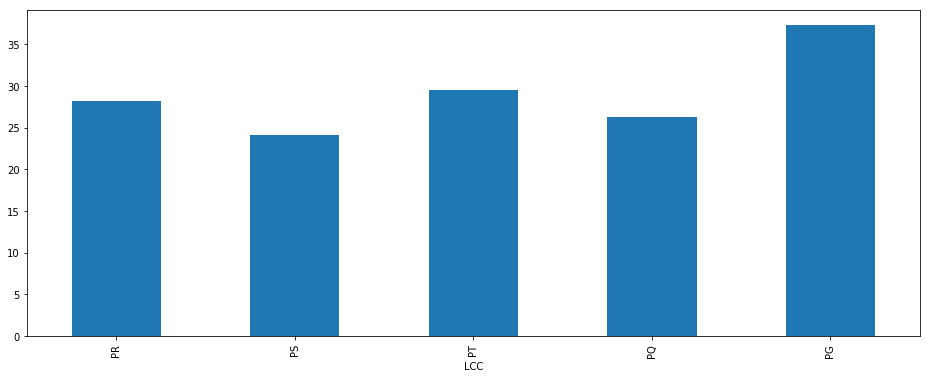

In [176]:
df.groupby(df['LCC'])['numChapters'].mean()[['PR', 'PS', 'PT', 'PQ', 'PG']].plot(kind='bar')

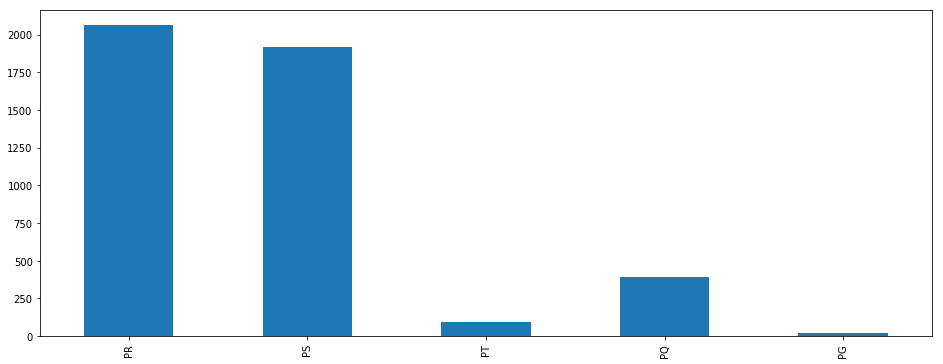

In [177]:
df['LCC'].value_counts()[['PR', 'PS', 'PT', 'PQ', 'PG']].plot(kind='bar')

# By LCSH

In [91]:
allSubj = {}
for i, row in df.iterrows(): 
    lcshRaw = row.lcsh
#     print(row.lcsh)
    try: 
        evaled = list(literal_eval(lcshRaw[0]))
    except: 
        continue
    for subj in evaled: 
        if subj in allSubj: 
            allSubj[subj].append(row['numChapters'])
        else: 
            allSubj[subj] = [row['numChapters']]

In [117]:
subjWithAtLeast5 = {k:v for k,v in allSubj.items() if len(v) > 30}

In [118]:
len(subjWithAtLeast5)

96

In [119]:
averages = {subj: np.mean(chaps) for subj, chaps in subjWithAtLeast5.items()}

In [127]:
avgChapsBySubject = {i: averages[i] for i in sorted(averages, key=averages.get, reverse=True)}

In [152]:
s = pd.Series(avgChapsBySubject)
s.sort_values(ascending=False)

English fiction -- 19th century                                  40.590909
Bildungsromans                                                   37.632911
Domestic fiction                                                 37.620690
Inheritance and succession -- Fiction                            37.440860
England -- Fiction                                               37.285714
Sisters -- Fiction                                               36.483871
Political fiction                                                35.301887
Young men -- Fiction                                             34.581395
Clergy -- Fiction                                                34.062500
Indexes                                                          33.846154
Married women -- Fiction                                         33.181818
Psychological fiction                                            33.164384
Courtship -- Fiction                                             32.558824
Didactic fiction         

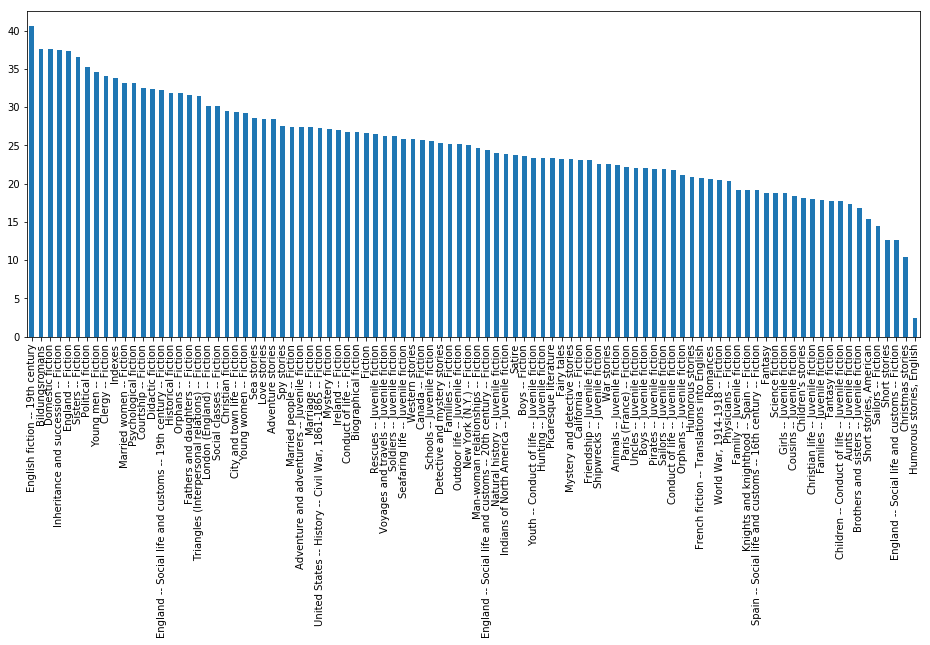

In [150]:
s.sort_values(ascending=False).plot(kind='bar')

# By Author Year of Birth

In [16]:
df.authoryearofbirth = df.authoryearofbirth.apply(lambda x: x[0])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b556f76d8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f2b5552e5c0>], dtype=object)

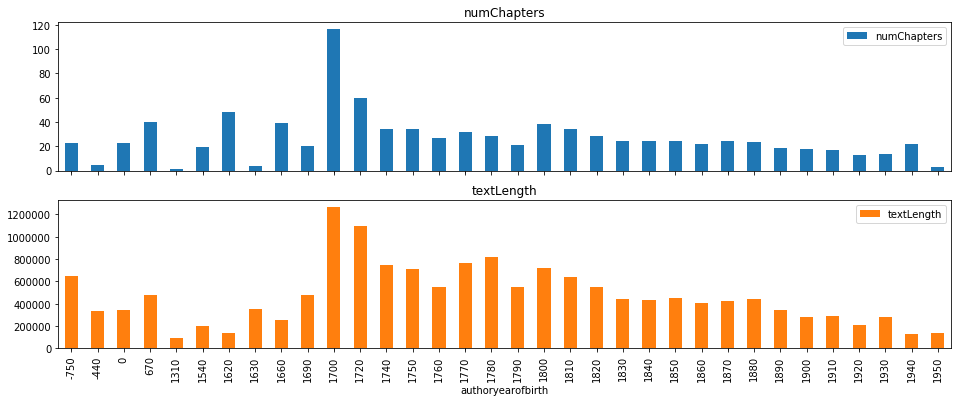

In [175]:
df.groupby(df['authoryearofbirth'].apply(lambda x: (int(x)//10)*10 if len(x)>0 else 0)).mean().plot(kind='bar', subplots=True)

# Average Chapter Length by Author DOB

In [13]:
df['averageChapLength'] = df['chapterLengths'].apply(np.mean)

/home/jon/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d28d76390>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f2d2821f320>], dtype=object)

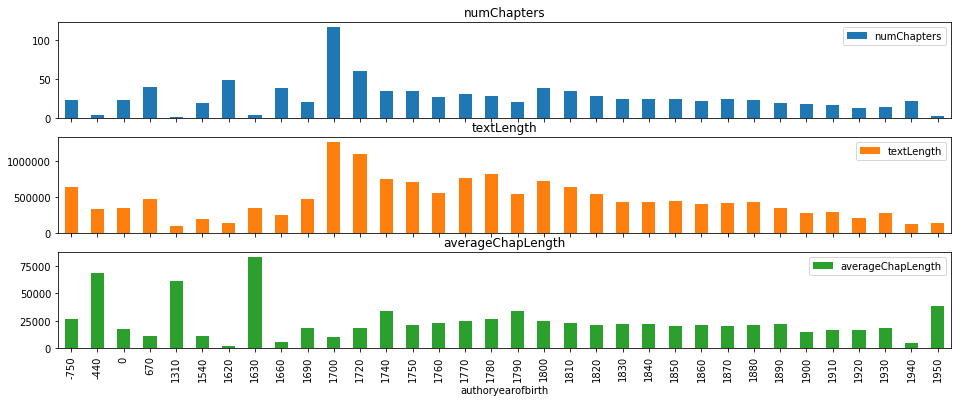

In [19]:
df.groupby(df['authoryearofbirth'].apply(lambda x: (int(x)//10)*10 if len(x)>0 else 0)).mean().plot(kind='bar', subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d20841240>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f2d207d5630>], dtype=object)

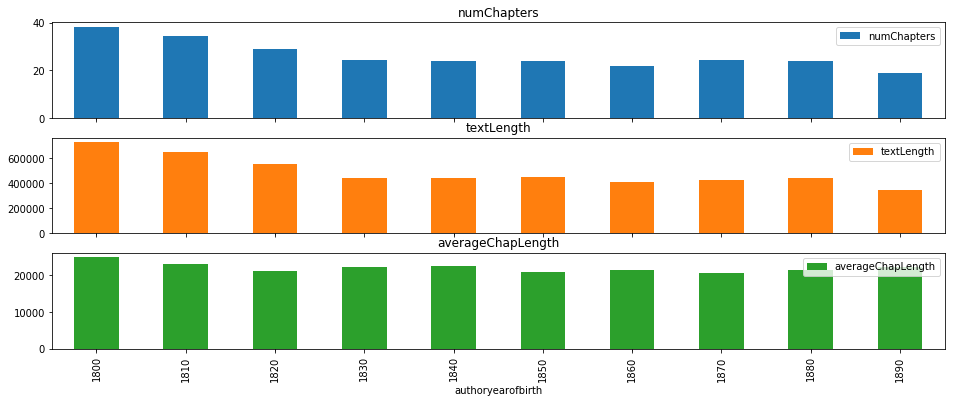

In [29]:
decs = df['authoryearofbirth'].apply(lambda x: (int(x)//10)*10 if len(x)>0 else 0)
df.groupby(decs).mean().loc[1800:1890].plot(kind='bar', subplots=True)

# Only British Literature

In [34]:
prdf = df[df['LCC']== 'PR']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d2051fba8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f2d20453b00>], dtype=object)

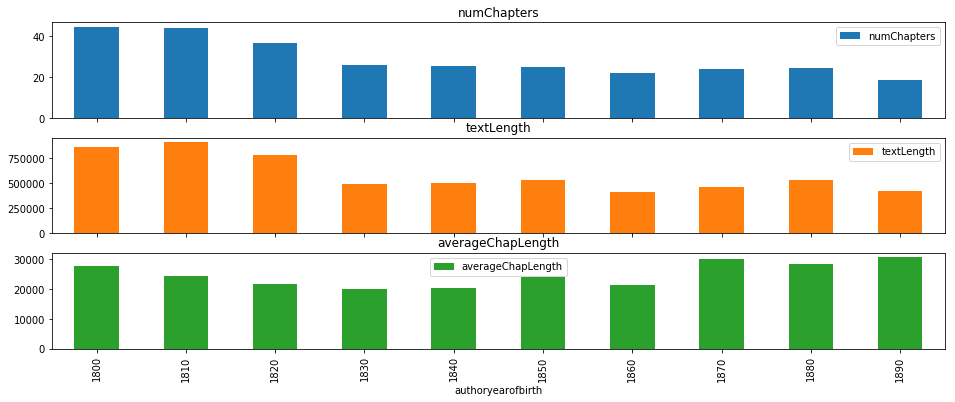

In [35]:
decs = prdf['authoryearofbirth'].apply(lambda x: (int(x)//10)*10 if len(x)>0 else 0)
prdf.groupby(decs).mean().loc[1800:1890].plot(kind='bar', subplots=True)

# British Lit by Subject

In [36]:
allSubj = {}
for i, row in prdf.iterrows(): 
    lcshRaw = row.lcsh
#     print(row.lcsh)
    try: 
        evaled = list(literal_eval(lcshRaw[0]))
    except: 
        continue
    for subj in evaled: 
        if subj in allSubj: 
            allSubj[subj].append(row['numChapters'])
        else: 
            allSubj[subj] = [row['numChapters']]

In [37]:
subjWithAtLeast5 = {k:v for k,v in allSubj.items() if len(v) > 30}

In [38]:
len(subjWithAtLeast5)

26

In [39]:
averages = {subj: np.mean(chaps) for subj, chaps in subjWithAtLeast5.items()}

In [40]:
avgChapsBySubject = {i: averages[i] for i in sorted(averages, key=averages.get, reverse=True)}

In [41]:
s = pd.Series(avgChapsBySubject)
s.sort_values(ascending=False)

Bildungsromans                                                   49.636364
Domestic fiction                                                 44.511905
English fiction -- 19th century                                  40.590909
England -- Fiction                                               38.793388
Inheritance and succession -- Fiction                            37.918033
Psychological fiction                                            37.411765
London (England) -- Fiction                                      34.446154
Indexes                                                          34.193548
Love stories                                                     33.764706
Triangles (Interpersonal relations) -- Fiction                   32.656250
Young women -- Fiction                                           31.947368
England -- Social life and customs -- 19th century -- Fiction    31.846154
Historical fiction                                               31.724138
Adventure stories        

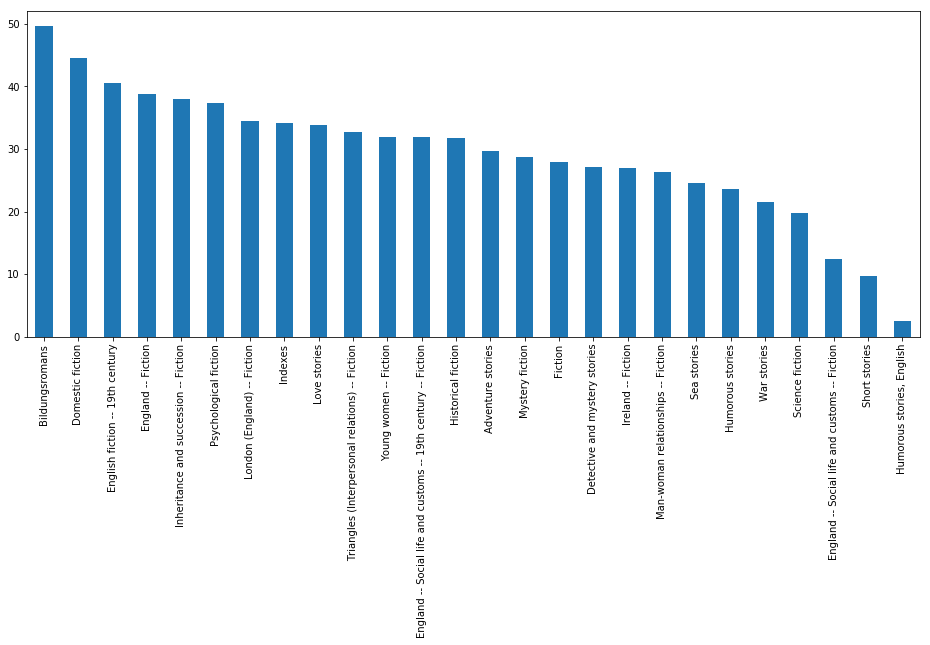

In [42]:
s.sort_values(ascending=False).plot(kind='bar')